In [ ]:
# Dataset : https://www.dropbox.com/home/Dataset.zip

!wget https://www.dropbox.com/s/kfykfe3rq931xeg/BrainTumorDataset.zip?dl=0

--2021-03-02 11:08:27--  https://www.dropbox.com/s/kfykfe3rq931xeg/BrainTumorDataset.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/kfykfe3rq931xeg/BrainTumorDataset.zip [following]
--2021-03-02 11:08:28--  https://www.dropbox.com/s/raw/kfykfe3rq931xeg/BrainTumorDataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc3ae8ee925f773a41f40bb6bab8.dl.dropboxusercontent.com/cd/0/inline/BJ7FRrVWZn9d1KZpn3TTrLWtfomGYt4Ou-fjmU1ZA_nN7Bw9Hx4VJcFdAJx2uonDqokw6zF0hmWzUJzN0gBxpLb51spkll7bXqJDEECQYGGoOO2nWi57fXxuJBsijAoevkw/file# [following]
--2021-03-02 11:08:28--  https://uc3ae8ee925f773a41f40bb6bab8.dl.dropboxusercontent.com/cd/0/inline/BJ7FRrVWZn9d1KZpn3TTrLWtfomGYt4Ou-fjmU1ZA_nN7Bw9Hx4VJcFdAJx2uonDqokw6zF0hmWzUJz

In [ ]:
!unzip BrainTumorDataset.zip

Archive:  BrainTumorDataset.zip
   creating: Dataset/no/
  inflating: Dataset/no/10 no.jpg    
  inflating: Dataset/no/11 no.jpg    
  inflating: Dataset/no/12 no.jpg    
  inflating: Dataset/no/13 no.jpg    
  inflating: Dataset/no/14 no.jpg    
  inflating: Dataset/no/15 no.jpg    
  inflating: Dataset/no/17 no.jpg    
  inflating: Dataset/no/18 no.jpg    
  inflating: Dataset/no/19 no.jpg    
  inflating: Dataset/no/1no.jpeg     
  inflating: Dataset/no/2 no.jpeg    
  inflating: Dataset/no/20 no.jpg    
  inflating: Dataset/no/21 no.jpg    
  inflating: Dataset/no/22 no.jpg    
  inflating: Dataset/no/23 no.jpg    
  inflating: Dataset/no/24 no.jpg    
  inflating: Dataset/no/25 no.jpg    
  inflating: Dataset/no/26 no.jpg    
  inflating: Dataset/no/27 no.jpg    
  inflating: Dataset/no/28 no.jpg    
  inflating: Dataset/no/29 no.jpg    
  inflating: Dataset/no/3 no.jpg     
  inflating: Dataset/no/30 no.jpg    
  inflating: Dataset/no/31 no.jpg    
  inflating: Dataset/no/32 no.j

In [ ]:
from IPython.display import clear_output
!pip install imutils
clear_output()

from keras.applications.vgg19 import VGG19,preprocess_input
from keras.applications.xception import Xception,preprocess_input
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50

In [ ]:
import numpy as np 
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping
from keras import *
init_notebook_mode(connected=True)
RANDOM_SEED = 123

In [ ]:
!apt-get install tree
#clear_output()
# create new folders
!mkdir TRAIN TEST VAL TRAIN/YES TRAIN/NO TEST/YES TEST/NO VAL/YES VAL/NO
!tree -d

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 13 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 0s (131 kB/s)
Selecting previously unselected package tree.
(Reading database ... 149406 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
.
├── Dataset
│   ├── no
│   └── yes
├── sample_data
├── TEST
│   ├── NO
│   └── YES
├── TRAIN
│   ├── NO
│   └── YES
└── VAL
    ├── NO
    └── YES

13 directories


In [ ]:
IMG_PATH = 'Dataset/'
# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            if n < 5:
                shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
            elif n < 0.8*IMG_NUM:
                shutil.copy(img, 'TRAIN/'+ CLASS.upper() + '/' + FILE_NAME)
            else:
                shutil.copy(img, 'VAL/'+ CLASS.upper() + '/' + FILE_NAME)

In [ ]:
def load_data(dir_path, img_size=(224,224)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224,224)

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|██████████| 2/2 [00:00<00:00,  3.58it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

100%|██████████| 2/2 [00:00<00:00, 14.29it/s]

193 images loaded from TRAIN/ directory.
10 images loaded from TEST/ directory.
50 images loaded from VAL/ directory.


In [ ]:
import plotly.io as pio
pio.renderers.default = 'colab'

y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
iplot(fig)

In [ ]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

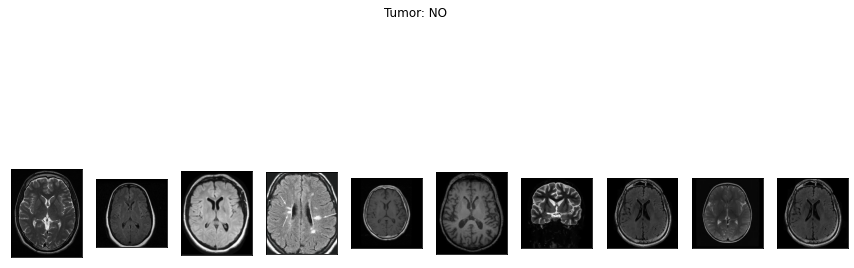

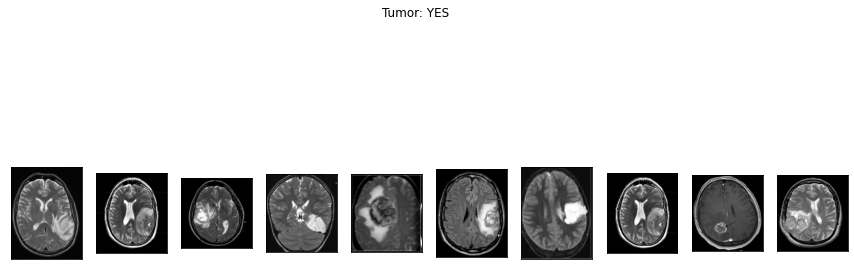

In [ ]:
plot_samples(X_train, y_train, labels, 10)

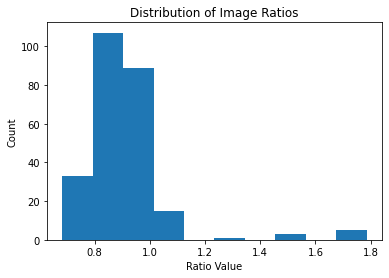

In [ ]:
RATIO_LIST = []
for set in (X_train, X_test, X_val):
    for img in set:
        RATIO_LIST.append(img.shape[1]/img.shape[0])
        
plt.hist(RATIO_LIST)
plt.title('Distribution of Image Ratios')
plt.xlabel('Ratio Value')
plt.ylabel('Count')
plt.show()

In [ ]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)

In [ ]:
img = cv2.imread('Dataset/yes/Y91.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)
# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

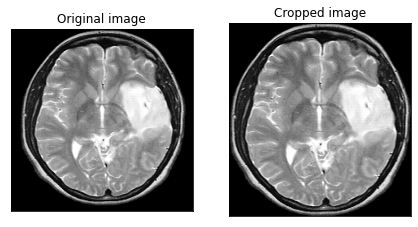

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Original image')
plt.subplot(142)
plt.imshow(new_img)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Cropped image')
plt.show()

In [ ]:
# apply this for each set
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



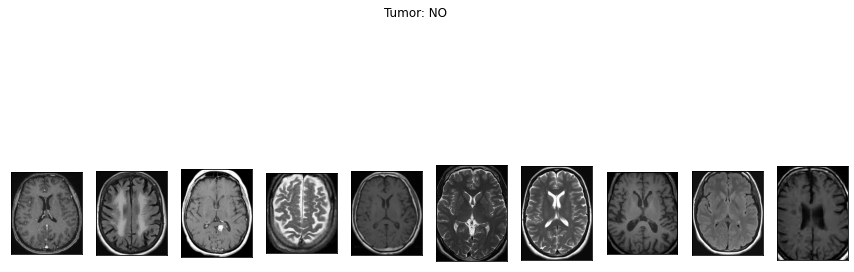

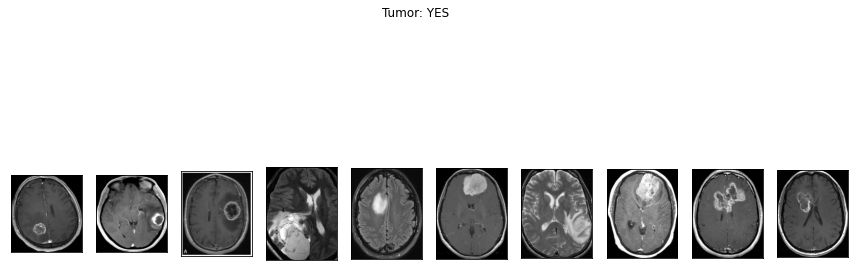

In [ ]:
plot_samples(X_train_crop, y_train, labels, 10)

In [ ]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [ ]:
# saving new images to the folder
!mkdir TRAIN_CROP TEST_CROP VAL_CROP TRAIN_CROP/YES TRAIN_CROP/NO TEST_CROP/YES TEST_CROP/NO VAL_CROP/YES VAL_CROP/NO

save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')

In [ ]:
def preprocess_imgs(set_name, img_size):
  
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [ ]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

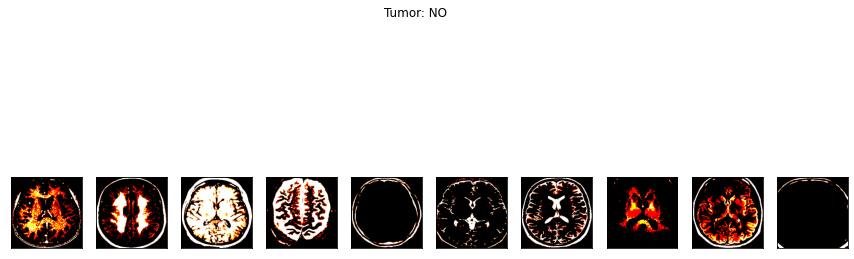

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

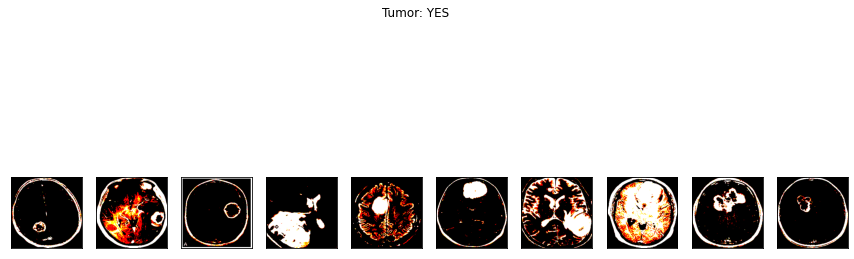

In [ ]:
 plot_samples(X_train_prep, y_train, labels, 10)

In [ ]:
# set the paramters we want to change randomly
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

In [ ]:
os.mkdir('preview')
x = X_train_crop[10]  
x = x.reshape((1,) + x.shape) 

i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break 

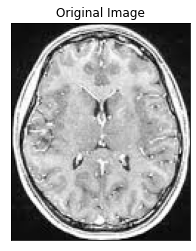

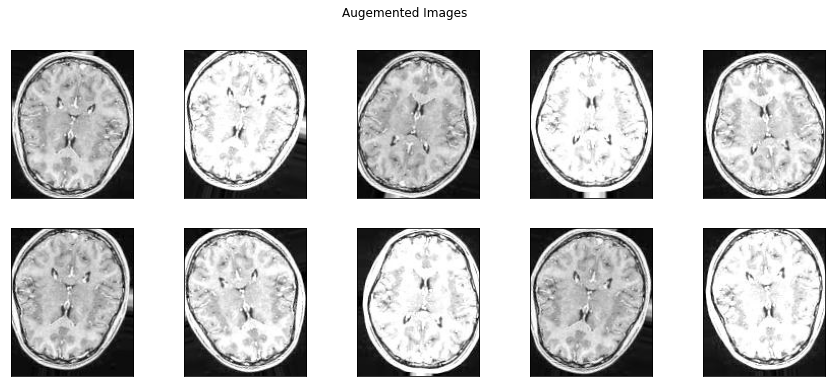

In [ ]:
plt.imshow(X_train_crop[10])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview/'):
    img = cv2.cv2.imread('preview/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(2,5,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 2*5:
        break
plt.suptitle('Augemented Images')
plt.show()

In [ ]:
!rm -rf preview/

In [ ]:
TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 193 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


# **VGG 16**

In [ ]:

# load base model
vgg16_weight_path = 'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
vgg = VGG16(
    weights='imagenet',
    include_top=False,    #Last layer or output layer is removed
    input_shape=IMG_SIZE + (3,)
)

# load base model
# ResNet50_weight_path = '/content/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
# resnet50_x = ResNet50(
#     weights=ResNet50_weight_path,
#     include_top=False, 
#     input_shape=IMG_SIZE + (3,)
# )

58892288/58889256 [==============================] - 0s 0us/step


553467904/553467096 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
Total params: 1,792
Trainable params: 1,792
Non-trainable params: 0
_________________________________________________________________


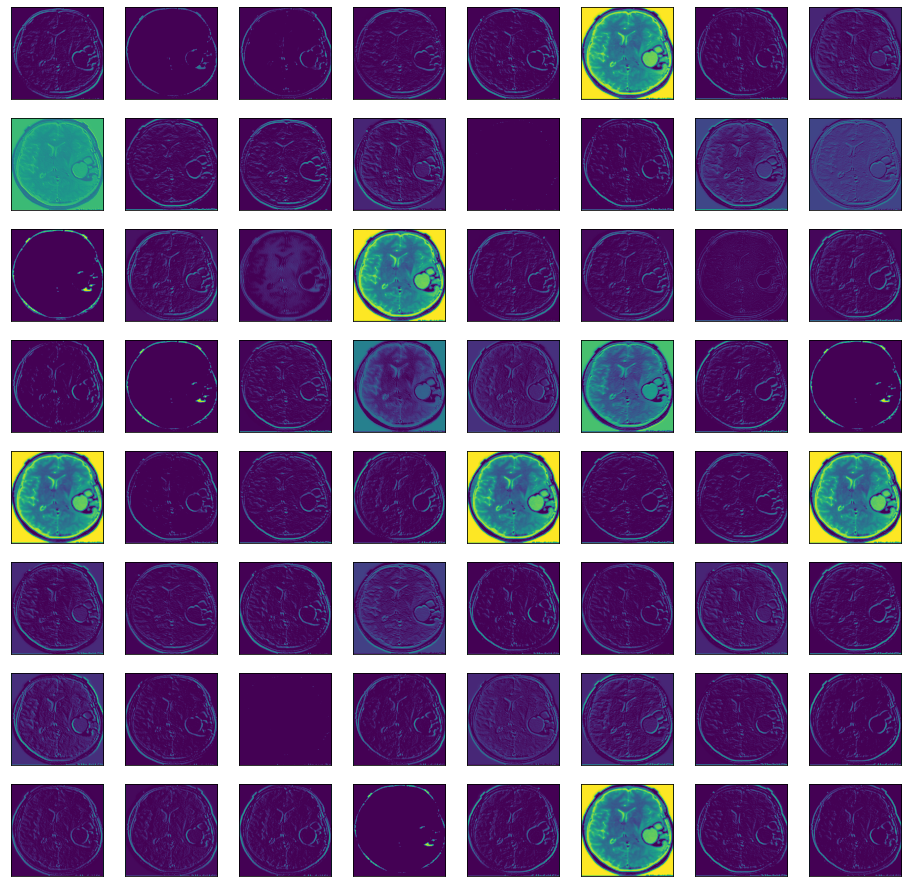

In [ ]:
# plot feature map of first conv layer for given image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from matplotlib import pyplot 
from numpy import expand_dims


f = plt.figure(figsize=(16,16))
# load the modelf = plt.figure(figsize=(10,3))
model = VGG16()
# redefine model to output right after the first hidden layer
model = Model(inputs=model.inputs, outputs=model.layers[1].output)
model.summary()
# load the image with the required shape
# convert the image to an array
img = img_to_array(X_val_prep[43])
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model.predict(img)
# plot all 64 maps in an 8x8 squares
square = 8
ix = 1
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = pyplot.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='viridis')
		ix += 1
# show the figure
pyplot.show()

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

NUM_CLASSES = 1

vgg16 = Sequential()
vgg16.add(vgg)
vgg16.add(layers.Dropout(0.3))
vgg16.add(layers.Flatten())
vgg16.add(layers.Dropout(0.5))

vgg16.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

vgg16.layers[0].trainable = False         #Freeze the VGG-16 layers

vgg16.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)
vgg16.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0003, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), metrics=["accuracy"])

vgg16.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 25089     
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
# visualize feature maps output from each block in the vgg model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
import matplotlib.pyplot as plt
from numpy import expand_dims




# load the model
model = VGG16()
# redefine model to output right after the first hidden layer
ixs = [2, 5, 9, 13, 17]
outputs = [model.layers[i].output for i in ixs]
model = Model(inputs=model.inputs, outputs=outputs)
# load the image with the required shape
# convert the image to an array
img = img_to_array(X_val_prep[43])
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model.predict(img)
# plot the output from each block
square = 8
for fmap in feature_maps:
	# plot all 64 maps in an 8x8 squares
	ix = 1
	for _ in range(square):
		plt.figure(figsize=(64,64))
		for _ in range(square):
           

			# specify subplot and turn of axis
			ax = pyplot.subplot(square, square, ix)
			ax.set_xticks([])
			ax.set_yticks([])
			
			# plot filter channel in grayscale
			plt.imshow(fmap[0, :, :, ix-1], cmap='viridis')
			ix += 1
	# show the figure

        
	plt.show()

In [ ]:
import time

start = time.time()



vgg16_history = vgg16.fit_generator(
    train_generator,
    steps_per_epoch=6,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)


end = time.time()
print(end - start)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/50
6/6 [==============================] - 109s 18s/step - loss: 5.9253 - accuracy: 0.5379 - val_loss: 4.1499 - val_accuracy: 0.5800
Epoch 2/50
6/6 [==============================] - 106s 18s/step - loss: 7.1158 - accuracy: 0.5239 - val_loss: 3.6945 - val_accuracy: 0.6000
Epoch 3/50
6/6 [==============================] - 106s 21s/step - loss: 3.3045 - accuracy: 0.6463 - val_loss: 3.2759 - val_accuracy: 0.5600
Epoch 4/50
6/6 [==============================] - 106s 18s/step - loss: 5.0638 - accuracy: 0.6945 - val_loss: 3.3693 - val_accuracy: 0.5800
Epoch 5/50
6/6 [==============================] - 106s 21s/step - loss: 4.8396 - accuracy: 0.5876 - val_loss: 2.4867 - val_accuracy: 0.6000
Epoch 6/50
6/6 [==============================] - 106s 18s/step - loss: 3.8624 - accuracy: 0.7281 - val_loss: 1.9097 - val_accuracy: 0.7000
Epoch 7/50
6/6 [==============================] - 106s 18s/step - loss: 4.2477 - accuracy: 0.7016 - val_loss: 1.5119 - val_accuracy: 0.7200
Epoch 8/50
6/6 [====

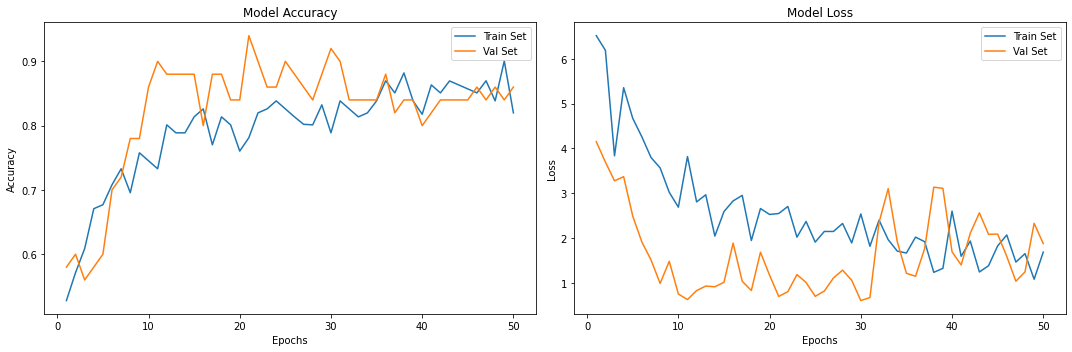

In [ ]:
# plot model performance
acc = vgg16_history.history['accuracy']
val_acc = vgg16_history.history['val_accuracy']
loss = vgg16_history.history['loss']
val_loss = vgg16_history.history['val_loss']
epochs_range = range(1, len(vgg16_history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

Val Accuracy = 0.900000


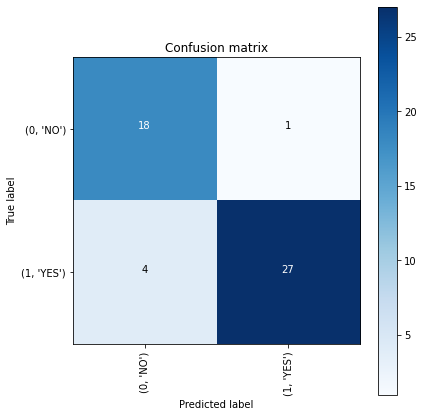

In [ ]:
# validate on val set
predictions = vgg16.predict(X_val_prep)
predictions = [1 if x>0.25 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %f'%accuracy)
confusion_mtx = confusion_matrix(y_val, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

In [ ]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_val, predictions)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_val, predictions)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_val, predictions)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_val, predictions)
print('F1 score: %f' % f1)

Accuracy: 0.900000
Precision: 0.964286
Recall: 0.870968
F1 score: 0.915254


In [ ]:
kappa = cohen_kappa_score(y_val, predictions)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_val, predictions)
print('ROC AUC: %f' % auc)

Cohens kappa: 0.794069
ROC AUC: 0.909168


Test Accuracy = 1.00


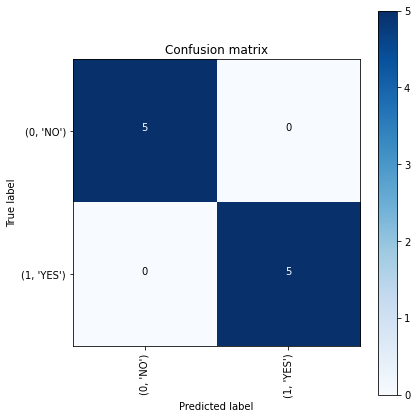

In [ ]:
# validate on test set
predictions = vgg16.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

# **ResNet50**

In [ ]:
# load base model
#resnet_weight_path = 'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
resnet = ResNet50(
    weights='imagenet',
    include_top=False, 
    input_shape=IMG_SIZE + (3,)
)

# load base model
# ResNet50_weight_path = '/content/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
# resnet50_x = ResNet50(
#     weights=ResNet50_weight_path,
#     include_top=False, 
#     input_shape=IMG_SIZE + (3,)
# )

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers


NUM_CLASSES = 1

res = Sequential()
res.add(resnet)
res.add(layers.Dropout(0.3))
res.add(layers.Flatten())
res.add(layers.Dropout(0.5))
res.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

res.layers[0].trainable = False

res.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

res.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0003, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), metrics=["accuracy"])


res.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 2048)        0         
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 1)                 100353    
Total params: 23,688,065
Trainable params: 100,353
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
import time

start = time.time()


res_history = res.fit_generator(
    train_generator,
    steps_per_epoch=6,
    epochs=50,
    validation_data=validation_generator,
    
)

end = time.time()
print(end - start)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/50
6/6 [==============================] - 40s 6s/step - loss: 2.2203 - accuracy: 0.5343 - val_loss: 0.6159 - val_accuracy: 0.7800
Epoch 2/50
6/6 [==============================] - 36s 6s/step - loss: 0.9948 - accuracy: 0.7009 - val_loss: 0.5013 - val_accuracy: 0.8600
Epoch 3/50
6/6 [==============================] - 47s 9s/step - loss: 0.6035 - accuracy: 0.8231 - val_loss: 0.4864 - val_accuracy: 0.9000
Epoch 4/50
6/6 [==============================] - 36s 6s/step - loss: 0.8432 - accuracy: 0.8096 - val_loss: 0.3827 - val_accuracy: 0.9200
Epoch 5/50
6/6 [==============================] - 36s 6s/step - loss: 0.4921 - accuracy: 0.8443 - val_loss: 0.5333 - val_accuracy: 0.9000
Epoch 6/50
6/6 [==============================] - 35s 6s/step - loss: 0.8801 - accuracy: 0.8152 - val_loss: 0.4698 - val_accuracy: 0.8800
Epoch 7/50
6/6 [==============================] - 36s 6s/step - loss: 0.7066 - accuracy: 0.8231 - val_loss: 0.6490 - val_accuracy: 0.8600
Epoch 8/50
6/6 [==================

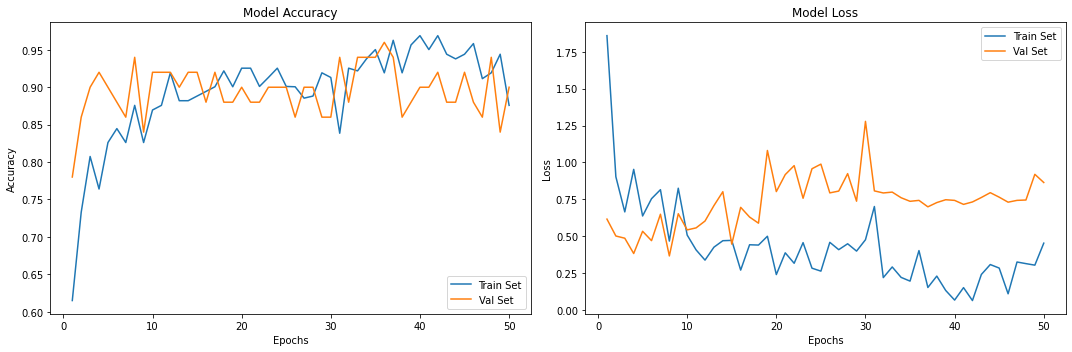

In [ ]:
# plot model performance
acc = res_history.history['accuracy']
val_acc = res_history.history['val_accuracy']
loss = res_history.history['loss']
val_loss = res_history.history['val_loss']
epochs_range = range(1, len(res_history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

Val Accuracy = 0.960000


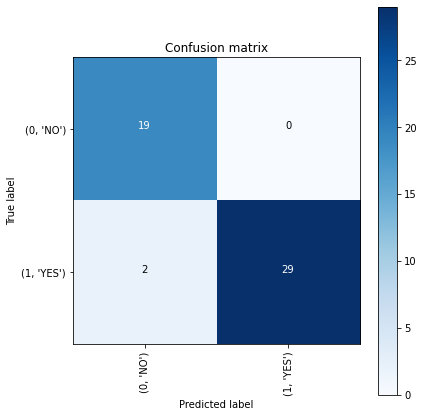

In [ ]:
# validate on val set
predictions = res.predict(X_val_prep)
predictions = [1 if x>0.95 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %f'%accuracy)
confusion_mtx = confusion_matrix(y_val, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

In [ ]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_val, predictions)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_val, predictions)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_val, predictions)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_val, predictions)
print('F1 score: %f' % f1)

Accuracy: 0.960000
Precision: 1.000000
Recall: 0.935484
F1 score: 0.966667


In [ ]:
kappa = cohen_kappa_score(y_val, predictions)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_val, predictions)
print('ROC AUC: %f' % auc)

Cohens kappa: 0.916805
ROC AUC: 0.967742


Test Accuracy = 0.90


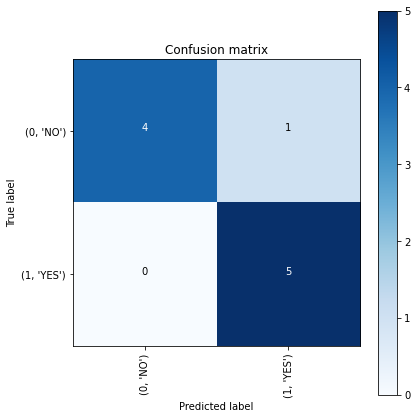

In [ ]:
# validate on test set
predictions = res.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

# **Inception V3**

In [ ]:
# load base model
InceptionV3_weight_path = '../input/keras-pretrained-models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
inceptionV3 = InceptionV3(
    weights='imagenet',
    include_top=False, 
    input_shape=IMG_SIZE + (3,)
)

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

NUM_CLASSES = 1

inception_v3 = Sequential()
inception_v3.add(inceptionV3)
inception_v3.add(layers.Dropout(0.3))
inception_v3.add(layers.Flatten())
inception_v3.add(layers.Dropout(0.5))
inception_v3.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

inception_v3.layers[0].trainable = False

inception_v3.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

inception_v3.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0003, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), metrics=["accuracy"])


inception_v3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 2048)        0         
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 51200)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51201     
Total params: 21,853,985
Trainable params: 51,201
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
import time

start = time.time()

# early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

inception_v3_history = inception_v3.fit_generator(
    train_generator,
    steps_per_epoch=6,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    # callbacks=[early_stop]
)

end = time.time()
print(end - start)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/50
6/6 [==============================] - 29s 4s/step - loss: 21.5047 - accuracy: 0.4839 - val_loss: 8.6517 - val_accuracy: 0.4800
Epoch 2/50
6/6 [==============================] - 23s 4s/step - loss: 16.6424 - accuracy: 0.5667 - val_loss: 12.2487 - val_accuracy: 0.6200
Epoch 3/50
6/6 [==============================] - 23s 4s/step - loss: 16.7124 - accuracy: 0.5644 - val_loss: 7.1387 - val_accuracy: 0.5200
Epoch 4/50
6/6 [==============================] - 22s 4s/step - loss: 13.5408 - accuracy: 0.5417 - val_loss: 7.6450 - val_accuracy: 0.7000
Epoch 5/50
6/6 [==============================] - 22s 4s/step - loss: 17.0594 - accuracy: 0.5193 - val_loss: 4.8556 - val_accuracy: 0.5800
Epoch 6/50
6/6 [==============================] - 22s 4s/step - loss: 13.1180 - accuracy: 0.5506 - val_loss: 4.3829 - val_accuracy: 0.5600
Epoch 7/50
6/6 [==============================] - 25s 4s/step - loss: 10.9796 - accuracy: 0.6522 - val_loss: 3.3367 - val_accuracy: 0.7400
Epoch 8/50
6/6 [==========

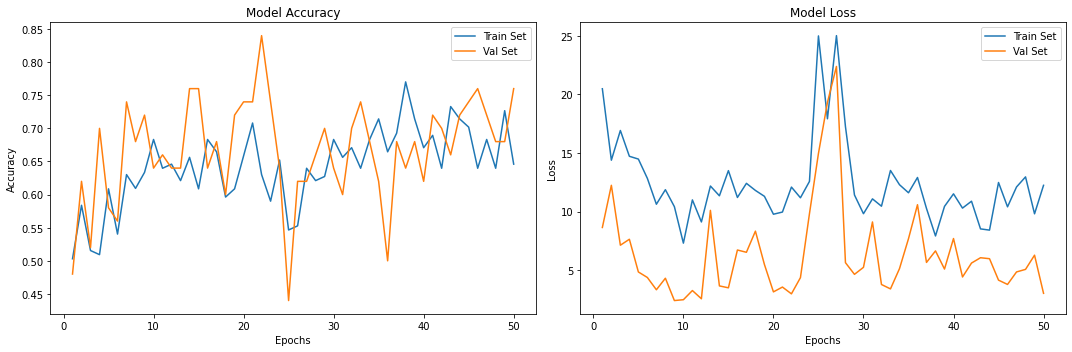

In [ ]:
# plot model performance
acc = inception_v3_history.history['accuracy']
val_acc = inception_v3_history.history['val_accuracy']
loss = inception_v3_history.history['loss']
val_loss = inception_v3_history.history['val_loss']
epochs_range = range(1, len(inception_v3_history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

Val Accuracy = 0.720000


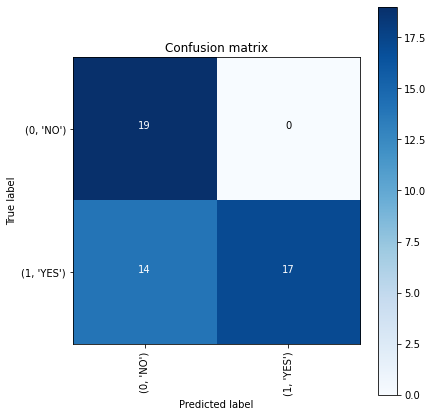

In [ ]:
# validate on val set
predictions = inception_v3.predict(X_val_prep)
predictions = [1 if x>0.95 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %f'%accuracy)
confusion_mtx = confusion_matrix(y_val, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

In [ ]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_val, predictions)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_val, predictions)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_val, predictions)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_val, predictions)
print('F1 score: %f' % f1)

Accuracy: 0.720000
Precision: 1.000000
Recall: 0.548387
F1 score: 0.708333


In [ ]:
kappa = cohen_kappa_score(y_val, predictions)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_val, predictions)
print('ROC AUC: %f' % auc)

Cohens kappa: 0.479941
ROC AUC: 0.774194


Test Accuracy = 1.00


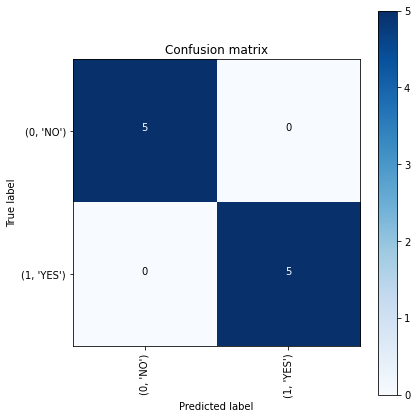

In [ ]:
# validate on test set
predictions = inception_v3.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

# **Xception**

In [ ]:
# load base model
Xception_weight_path = '../input/keras-pretrained-models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
xception = Xception(
    weights='imagenet',
    include_top=False, 
    input_shape=IMG_SIZE + (3,)
)

83689472/83683744 [==============================] - 1s 0us/step


In [ ]:
NUM_CLASSES = 1

xception_ = Sequential()
xception_.add(xception)
xception_.add(layers.Dropout(0.3))
xception_.add(layers.Flatten())
xception_.add(layers.Dropout(0.5))
xception_.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

xception_.layers[0].trainable = False

xception_.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

# xception_.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0003, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), metrics=["accuracy"])


xception_.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 2048)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 100352)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 100353    
Total params: 20,961,833
Trainable params: 100,353
Non-trainable params: 20,861,480
_________________________________________________________________


In [ ]:
import time

start = time.time()

# early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)

xception_history = xception_.fit_generator(
    train_generator,
    steps_per_epoch=6,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    # callbacks=[early_stop]
)

end = time.time()
print(end - start)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/50
6/6 [==============================] - 48s 9s/step - loss: 3.8110 - accuracy: 0.5264 - val_loss: 1.9232 - val_accuracy: 0.6200
Epoch 2/50
6/6 [==============================] - 43s 7s/step - loss: 3.9004 - accuracy: 0.4852 - val_loss: 1.8995 - val_accuracy: 0.6400
Epoch 3/50
6/6 [==============================] - 42s 7s/step - loss: 2.8779 - accuracy: 0.5360 - val_loss: 1.3480 - val_accuracy: 0.6600
Epoch 4/50
6/6 [==============================] - 48s 8s/step - loss: 3.3107 - accuracy: 0.5627 - val_loss: 1.0497 - val_accuracy: 0.5800
Epoch 5/50
6/6 [==============================] - 42s 7s/step - loss: 3.0555 - accuracy: 0.5090 - val_loss: 2.4045 - val_accuracy: 0.6400
Epoch 6/50
6/6 [==============================] - 42s 8s/step - loss: 5.3424 - accuracy: 0.5213 - val_loss: 1.1000 - val_accuracy: 0.5400
Epoch 7/50
6/6 [==============================] - 43s 7s/step - loss: 2.8640 - accuracy: 0.5499 - val_loss: 1.3700 - val_accuracy: 0.6600
Epoch 8/50
6/6 [==================

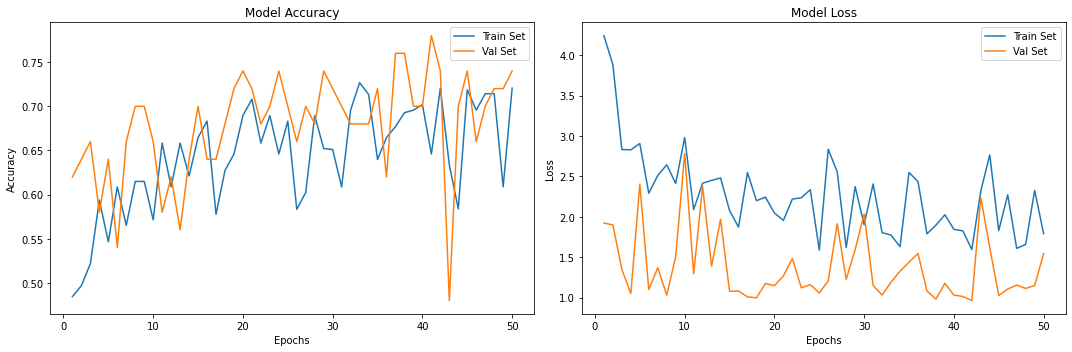

In [ ]:
# plot model performance
acc = xception_history.history['accuracy']
val_acc = xception_history.history['val_accuracy']
loss = xception_history.history['loss']
val_loss = xception_history.history['val_loss']
epochs_range = range(1, len(xception_history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

Val Accuracy = 0.720000


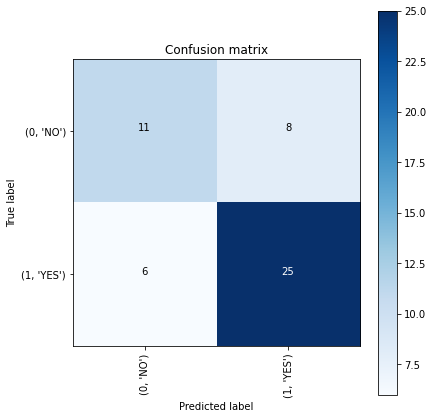

In [ ]:
# validate on val set
predictions = xception_.predict(X_val_prep)
predictions = [1 if x>0.95 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %f'%accuracy)
confusion_mtx = confusion_matrix(y_val, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

In [ ]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_val, predictions)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_val, predictions)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_val, predictions)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_val, predictions)
print('F1 score: %f' % f1)

Accuracy: 0.720000
Precision: 0.757576
Recall: 0.806452
F1 score: 0.781250


In [ ]:
kappa = cohen_kappa_score(y_val, predictions)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_val, predictions)
print('ROC AUC: %f' % auc)

Cohens kappa: 0.393414
ROC AUC: 0.692699


Test Accuracy = 0.50


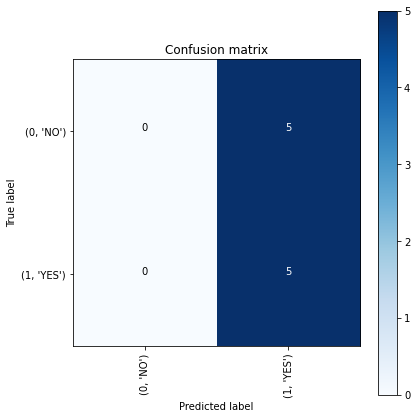

In [ ]:
# validate on test set
predictions = xception_.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

# **InceptionResnetV2**

In [ ]:
from tensorflow.python.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

In [ ]:
# load base model
#inception_resnet_V2_weight_path = '../input/keras-pretrained-models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
irnv2 = InceptionResNetV2(
    weights='imagenet',
    include_top=False, 
    input_shape=(IMG_SIZE + (3,))
)

In [ ]:
from tensorflow import keras
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D, BatchNormalization

NUM_CLASSES = 1

inception_resnet_v2_ = Sequential()


inception_resnet_v2_.add(irnv2)

inception_resnet_v2_.add(GlobalAveragePooling2D())
inception_resnet_v2_.add(layers.Dense(1,activation='sigmoid'))

inception_resnet_v2_.layers[0].trainable = False

inception_resnet_v2_.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

inception_resnet_v2_.compile(loss=keras.losses.binary_crossentropy,optimizer='adam',metrics=['accuracy'])


inception_resnet_v2_.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 5, 5, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1536)              0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 1537      
Total params: 54,338,273
Trainable params: 1,537
Non-trainable params: 54,336,736
_________________________________________________________________


In [ ]:
import time

start = time.time()

# early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)

irnv2_history = inception_resnet_v2_.fit_generator(
    train_generator,
    steps_per_epoch=7,
    epochs=50,
    validation_data=validation_generator,
    # callbacks=[early_stop]
)

end = time.time()
print(end - start)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/50
7/7 [==============================] - 81s 9s/step - loss: 28.9445 - accuracy: 0.4000 - val_loss: 0.9567 - val_accuracy: 0.7400
Epoch 2/50
7/7 [==============================] - 62s 9s/step - loss: 10.2856 - accuracy: 0.6433 - val_loss: 13.3973 - val_accuracy: 0.3800
Epoch 3/50
7/7 [==============================] - 63s 10s/step - loss: 18.8200 - accuracy: 0.3976 - val_loss: 14.7922 - val_accuracy: 0.6200
Epoch 4/50
7/7 [==============================] - 61s 9s/step - loss: 13.3156 - accuracy: 0.6144 - val_loss: 1.5613 - val_accuracy: 0.6400
Epoch 5/50
7/7 [==============================] - 63s 10s/step - loss: 10.2344 - accuracy: 0.5453 - val_loss: 1.1337 - val_accuracy: 0.7000
Epoch 6/50
7/7 [==============================] - 60s 9s/step - loss: 7.5207 - accuracy: 0.4990 - val_loss: 14.4182 - val_accuracy: 0.6200
Epoch 7/50
7/7 [==============================] - 61s 9s/step - loss: 13.1695 - accuracy: 0.6232 - val_loss: 16.1700 - val_accuracy: 0.3800
Epoch 8/50
7/7 [======

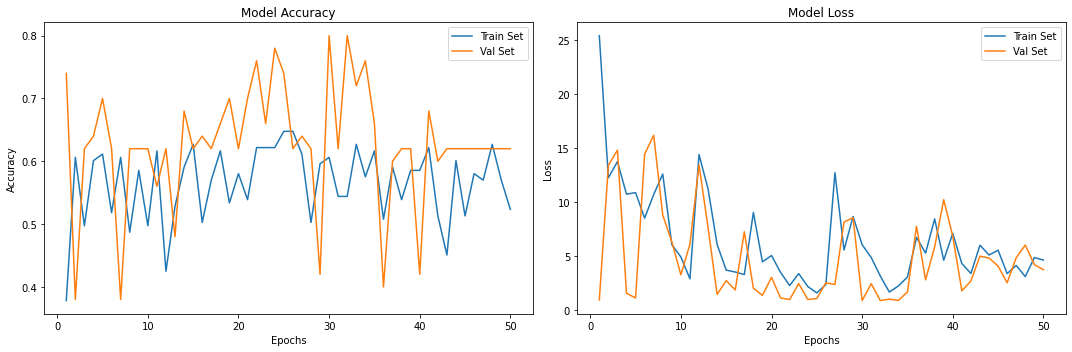

In [ ]:
# plot model performance
acc = irnv2_history.history['accuracy']
val_acc = irnv2_history.history['val_accuracy']
loss = irnv2_history.history['loss']
val_loss = irnv2_history.history['val_loss']
epochs_range = range(1, len(irnv2_history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

Val Accuracy = 0.640000


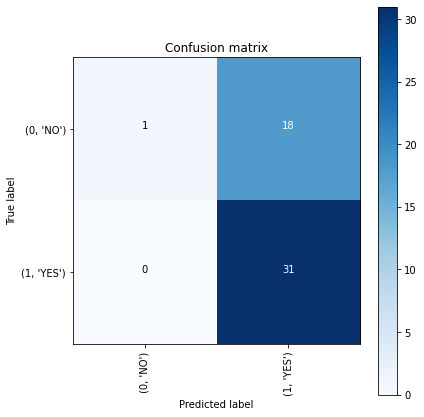

In [ ]:
# validate on val set
predictions = inception_resnet_v2_.predict(X_val_prep)
predictions = [1 if x>0.95 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %f'%accuracy)
confusion_mtx = confusion_matrix(y_val, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

In [ ]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_val, predictions)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_val, predictions)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_val, predictions)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_val, predictions)
print('F1 score: %f' % f1)

Accuracy: 0.640000
Precision: 0.632653
Recall: 1.000000
F1 score: 0.775000


In [ ]:
kappa = cohen_kappa_score(y_val, predictions)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_val, predictions)
print('ROC AUC: %f' % auc)

Cohens kappa: 0.064449
ROC AUC: 0.526316


Test Accuracy = 0.50


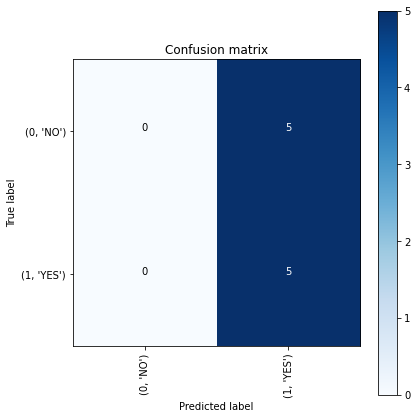

In [ ]:
# validate on test set
predictions = inception_resnet_v2_.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

# **MobileNet**

In [ ]:
from keras.applications.mobilenet import MobileNet, preprocess_input

# load base model
MobileNet_weight_path = '../input/keras-pretrained-models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
mobilenet = MobileNet(
    weights='imagenet',
    include_top=False, 
    input_shape=IMG_SIZE + (3,)
)

17227776/17225924 [==============================] - 1s 0us/step


In [ ]:
from tensorflow import keras


NUM_CLASSES = 1

mobile_net = Sequential()
mobile_net.add(mobilenet)
mobile_net.add(layers.Dropout(0.5))
mobile_net.add(layers.Flatten())
mobile_net.add(layers.Dropout(0.5))
mobile_net.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

mobile_net.layers[0].trainable = False

mobile_net.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

mobile_net.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0003, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), metrics=["accuracy"])


mobile_net.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 7, 1024)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 50176)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 50177     
Total params: 3,279,041
Trainable params: 50,177
Non-trainable params: 3,228,864
_________________________________________________________________


In [ ]:
import time

start = time.time()

# early_stop = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=25)

mobile_net_history = mobile_net.fit_generator(
    train_generator,
    steps_per_epoch=6,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    # callbacks=[early_stop]
)

end = time.time()
print(end - start)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/50
6/6 [==============================] - 12s 2s/step - loss: 2.1615 - accuracy: 0.5197 - val_loss: 0.8522 - val_accuracy: 0.5400
Epoch 2/50
6/6 [==============================] - 10s 2s/step - loss: 1.6059 - accuracy: 0.6039 - val_loss: 0.9953 - val_accuracy: 0.6000
Epoch 3/50
6/6 [==============================] - 10s 2s/step - loss: 1.1720 - accuracy: 0.5445 - val_loss: 1.1530 - val_accuracy: 0.6400
Epoch 4/50
6/6 [==============================] - 10s 2s/step - loss: 1.4871 - accuracy: 0.5739 - val_loss: 1.3369 - val_accuracy: 0.6400
Epoch 5/50
6/6 [==============================] - 10s 2s/step - loss: 1.2731 - accuracy: 0.6626 - val_loss: 1.3343 - val_accuracy: 0.6400
Epoch 6/50
6/6 [==============================] - 10s 2s/step - loss: 1.3837 - accuracy: 0.6916 - val_loss: 1.3150 - val_accuracy: 0.5800
Epoch 7/50
6/6 [==============================] - 10s 2s/step - loss: 1.0837 - accuracy: 0.7336 - val_loss: 1.0333 - val_accuracy: 0.7200
Epoch 8/50
6/6 [==================

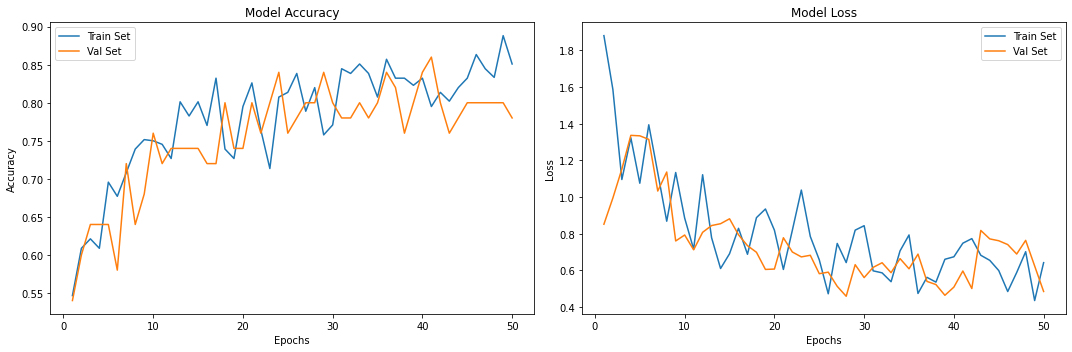

In [ ]:
# plot model performance
acc = mobile_net_history.history['accuracy']
val_acc = mobile_net_history.history['val_accuracy']
loss = mobile_net_history.history['loss']
val_loss = mobile_net_history.history['val_loss']
epochs_range = range(1, len(mobile_net_history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

Val Accuracy = 0.840000


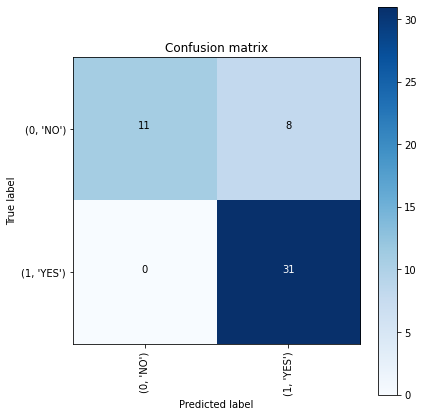

In [ ]:
# validate on val set
predictions = mobile_net.predict(X_val_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %f'%accuracy)
confusion_mtx = confusion_matrix(y_val, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

In [ ]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_val, predictions)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_val, predictions)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_val, predictions)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_val, predictions)
print('F1 score: %f' % f1)

Accuracy: 0.840000
Precision: 0.794872
Recall: 1.000000
F1 score: 0.885714


In [ ]:
kappa = cohen_kappa_score(y_val, predictions)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_val, predictions)
print('ROC AUC: %f' % auc)

Cohens kappa: 0.630314
ROC AUC: 0.789474


Test Accuracy = 0.80


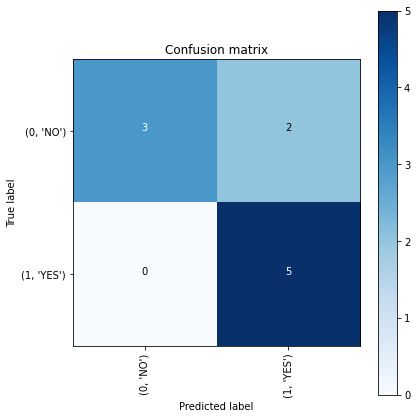

In [ ]:
# validate on test set
predictions = mobile_net.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

# **DenseNet**

In [ ]:
from keras.applications.densenet import DenseNet121


# load base model
Densenet121_weight_path = '../input/keras-pretrained-models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
densenet121 = DenseNet121(
    weights='imagenet',
    include_top=False, 
    input_shape=IMG_SIZE + (3,)
)

29089792/29084464 [==============================] - 1s 0us/step


In [ ]:
from tensorflow import keras


NUM_CLASSES = 1

dense_net_121 = Sequential()
dense_net_121.add(densenet121)
dense_net_121.add(layers.Dropout(0.3))
dense_net_121.add(layers.Flatten())
dense_net_121.add(layers.Dropout(0.5))
dense_net_121.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

dense_net_121.layers[0].trainable = False

dense_net_121.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

dense_net_121.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0003, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), metrics=["accuracy"])


dense_net_121.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
dropout_6 (Dropout)          (None, 7, 7, 1024)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 50176)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 50177     
Total params: 7,087,681
Trainable params: 50,177
Non-trainable params: 7,037,504
_________________________________________________________________


In [ ]:
import time

start = time.time()

# early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

dense_net_121_history = dense_net_121.fit(
    train_generator,
    steps_per_epoch=6,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    # callbacks=[early_stop]
)

end = time.time()
print(end - start)

Epoch 1/50
6/6 [==============================] - 38s 5s/step - loss: 7.6518 - accuracy: 0.5810 - val_loss: 3.3541 - val_accuracy: 0.4800
Epoch 2/50
6/6 [==============================] - 34s 6s/step - loss: 6.9489 - accuracy: 0.5519 - val_loss: 2.8323 - val_accuracy: 0.6400
Epoch 3/50
6/6 [==============================] - 29s 5s/step - loss: 6.3536 - accuracy: 0.5313 - val_loss: 2.4709 - val_accuracy: 0.6200
Epoch 4/50
6/6 [==============================] - 29s 5s/step - loss: 4.7216 - accuracy: 0.6321 - val_loss: 3.0045 - val_accuracy: 0.6400
Epoch 5/50
6/6 [==============================] - 34s 6s/step - loss: 4.7117 - accuracy: 0.6135 - val_loss: 3.1177 - val_accuracy: 0.6000
Epoch 6/50
6/6 [==============================] - 29s 6s/step - loss: 3.4388 - accuracy: 0.7117 - val_loss: 2.9871 - val_accuracy: 0.6000
Epoch 7/50
6/6 [==============================] - 30s 5s/step - loss: 4.1576 - accuracy: 0.6615 - val_loss: 4.2739 - val_accuracy: 0.6600
Epoch 8/50
6/6 [==================

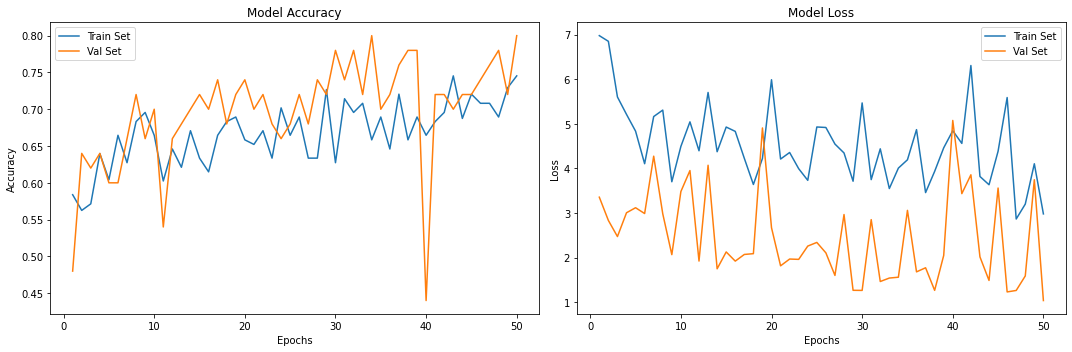

In [ ]:
# plot model performance
acc = dense_net_121_history.history['accuracy']
val_acc = dense_net_121_history.history['val_accuracy']
loss = dense_net_121_history.history['loss']
val_loss = dense_net_121_history.history['val_loss']
epochs_range = range(1, len(dense_net_121_history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

Val Accuracy = 0.780000


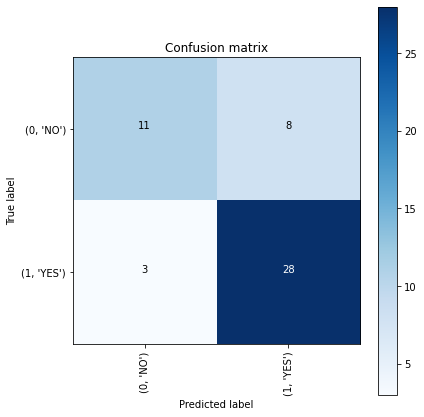

In [ ]:
# validate on val set
predictions = dense_net_121.predict(X_val_prep)
predictions = [1 if x>0.95 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %f'%accuracy)
confusion_mtx = confusion_matrix(y_val, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

In [ ]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_val, predictions)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_val, predictions)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_val, predictions)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_val, predictions)
print('F1 score: %f' % f1)

Accuracy: 0.780000
Precision: 0.777778
Recall: 0.903226
F1 score: 0.835821


In [ ]:
kappa = cohen_kappa_score(y_val, predictions)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_val, predictions)
print('ROC AUC: %f' % auc)

Cohens kappa: 0.508050
ROC AUC: 0.741087


Test Accuracy = 0.70


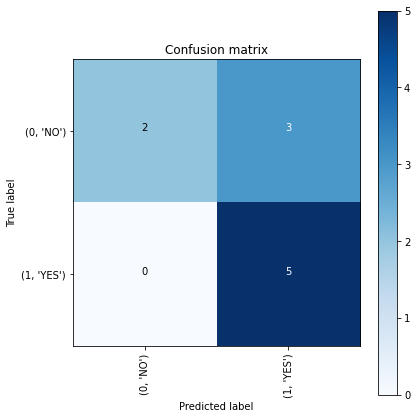

In [ ]:
# validate on test set
predictions = dense_net_121.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

# **NasNetMobile**

In [ ]:
from keras.applications.nasnet import NASNetMobile, NASNetLarge

In [ ]:

# load base model
NASnetMobile_weight_path = '../input/keras-pretrained-models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
NasNetMobile = NASNetMobile(
    weights='imagenet',
    include_top=False, 
    input_shape=IMG_SIZE + (3,)
)

19996672/19993432 [==============================] - 1s 0us/step


In [ ]:
from tensorflow import keras


NUM_CLASSES = 1

NAS_Net = Sequential()
NAS_Net.add(NasNetMobile)
NAS_Net.add(layers.Dropout(0.3))
NAS_Net.add(layers.Flatten())
NAS_Net.add(layers.Dropout(0.5))
NAS_Net.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

NAS_Net.layers[0].trainable = False

NAS_Net.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

NAS_Net.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0003, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), metrics=["accuracy"])


NAS_Net.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NASNet (Functional)          (None, 7, 7, 1056)        4269716   
_________________________________________________________________
dropout_10 (Dropout)         (None, 7, 7, 1056)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 51744)             0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 51744)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51745     
Total params: 4,321,461
Trainable params: 51,745
Non-trainable params: 4,269,716
_________________________________________________________________


In [ ]:
import time

start = time.time()

# early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

NAS_Net_history = NAS_Net.fit(
    train_generator,
    steps_per_epoch=6,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    # callbacks=[early_stop]
)

end = time.time()
print(end - start)

Epoch 1/50
6/6 [==============================] - 44s 6s/step - loss: 8.9377 - accuracy: 0.4509 - val_loss: 4.0366 - val_accuracy: 0.6000
Epoch 2/50
6/6 [==============================] - 26s 4s/step - loss: 8.0580 - accuracy: 0.5742 - val_loss: 4.0138 - val_accuracy: 0.6200
Epoch 3/50
6/6 [==============================] - 23s 4s/step - loss: 8.6076 - accuracy: 0.5676 - val_loss: 3.8054 - val_accuracy: 0.6600
Epoch 4/50
6/6 [==============================] - 23s 4s/step - loss: 8.0222 - accuracy: 0.5498 - val_loss: 3.1316 - val_accuracy: 0.7000
Epoch 5/50
6/6 [==============================] - 22s 4s/step - loss: 6.7366 - accuracy: 0.5256 - val_loss: 1.6311 - val_accuracy: 0.7600
Epoch 6/50
6/6 [==============================] - 23s 4s/step - loss: 5.8812 - accuracy: 0.5431 - val_loss: 1.4929 - val_accuracy: 0.6800
Epoch 7/50
6/6 [==============================] - 23s 4s/step - loss: 5.2291 - accuracy: 0.5173 - val_loss: 1.8757 - val_accuracy: 0.7400
Epoch 8/50
6/6 [==================

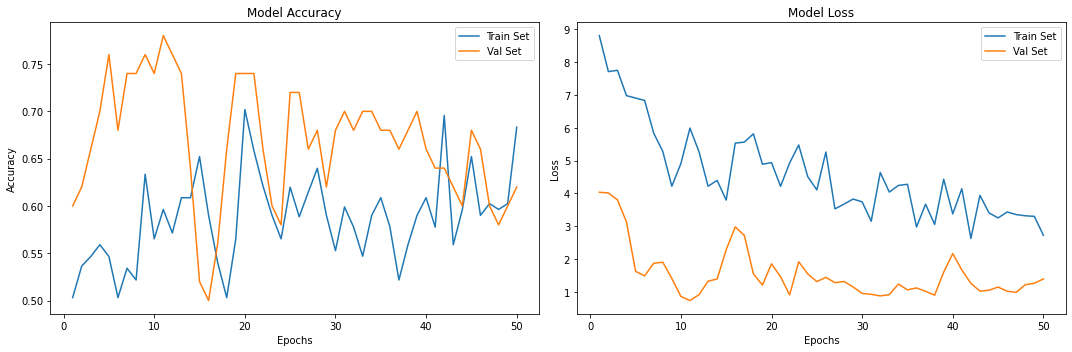

In [ ]:
# plot model performance
acc = NAS_Net_history.history['accuracy']
val_acc = NAS_Net_history.history['val_accuracy']
loss = NAS_Net_history.history['loss']
val_loss = NAS_Net_history.history['val_loss']
epochs_range = range(1, len(NAS_Net_history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

Val Accuracy = 0.680000


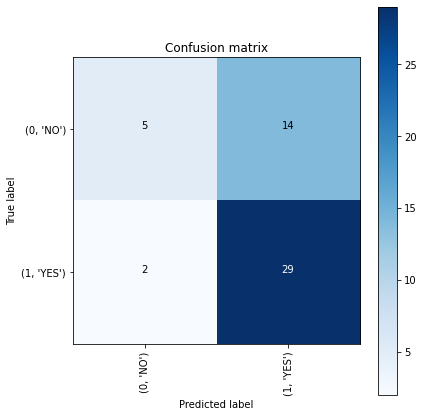

In [ ]:
# validate on val set
predictions = NAS_Net.predict(X_val_prep)
predictions = [1 if x>0.25 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %f'%accuracy)
confusion_mtx = confusion_matrix(y_val, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

In [ ]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_val, predictions)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_val, predictions)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_val, predictions)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_val, predictions)
print('F1 score: %f' % f1)

Accuracy: 0.680000
Precision: 0.674419
Recall: 0.935484
F1 score: 0.783784


In [ ]:
kappa = cohen_kappa_score(y_val, predictions)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_val, predictions)
print('ROC AUC: %f' % auc)

Cohens kappa: 0.226306
ROC AUC: 0.599321


Test Accuracy = 0.60


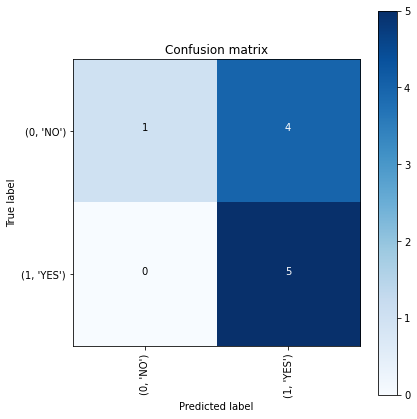

In [ ]:
# validate on test set
predictions = NAS_Net.predict(X_test_prep)
predictions = [1 if x>0.25 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

# **EfficientNets**

#### EfficientNetB0

In [ ]:
from tensorflow.keras.applications.efficientnet import EfficientNetB0,EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7

In [ ]:

# load base model
EfficientNetB0_weight_path = '../input/keras-pretrained-models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
EfficientnetB0 = EfficientNetB0(
    weights='imagenet',
    include_top=False, 
    input_shape=IMG_SIZE + (3,)
)

16711680/16705208 [==============================] - 0s 0us/step


In [ ]:
from tensorflow import keras


NUM_CLASSES = 1

EfficientnetB0_ = Sequential()
EfficientnetB0_.add(EfficientnetB0)
EfficientnetB0_.add(layers.Dropout(0.3))
EfficientnetB0_.add(layers.Flatten())
EfficientnetB0_.add(layers.Dropout(0.5))
EfficientnetB0_.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

EfficientnetB0_.layers[0].trainable = False

EfficientnetB0_.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

EfficientnetB0_.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0003, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), metrics=["accuracy"])


EfficientnetB0_.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
dropout_10 (Dropout)         (None, 7, 7, 1280)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 62720)             0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 62720)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 62721     
Total params: 4,112,292
Trainable params: 62,721
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
import time

start = time.time()



EfficientnetB0_history = EfficientnetB0_.fit_generator(
    train_generator,
    steps_per_epoch=6,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    
)

end = time.time()
print(end - start)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/50
6/6 [==============================] - 22s 3s/step - loss: 1.2728 - accuracy: 0.5159 - val_loss: 0.7153 - val_accuracy: 0.6800
Epoch 2/50
6/6 [==============================] - 14s 2s/step - loss: 0.7254 - accuracy: 0.6201 - val_loss: 0.8093 - val_accuracy: 0.7000
Epoch 3/50
6/6 [==============================] - 14s 3s/step - loss: 0.6984 - accuracy: 0.6768 - val_loss: 0.7410 - val_accuracy: 0.7000
Epoch 4/50
6/6 [==============================] - 15s 3s/step - loss: 0.4220 - accuracy: 0.8352 - val_loss: 0.7824 - val_accuracy: 0.7200
Epoch 5/50
6/6 [==============================] - 13s 2s/step - loss: 0.4961 - accuracy: 0.7966 - val_loss: 0.8925 - val_accuracy: 0.7000
Epoch 6/50
6/6 [==============================] - 13s 2s/step - loss: 0.6126 - accuracy: 0.7515 - val_loss: 0.9104 - val_accuracy: 0.6800
Epoch 7/50
6/6 [==============================] - 13s 3s/step - loss: 0.3475 - accuracy: 0.8882 - val_loss: 0.5284 - val_accuracy: 0.8200
Epoch 8/50
6/6 [==================

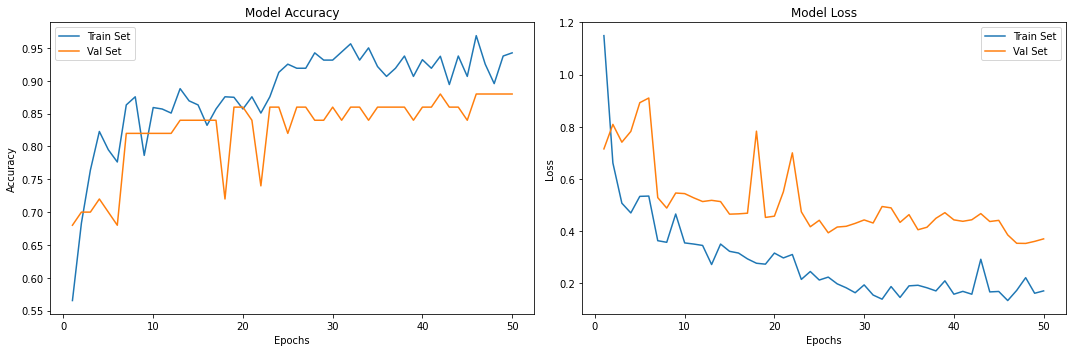

In [ ]:
# plot model performance
acc = EfficientnetB0_history.history['accuracy']
val_acc = EfficientnetB0_history.history['val_accuracy']
loss = EfficientnetB0_history.history['loss']
val_loss = EfficientnetB0_history.history['val_loss']
epochs_range = range(1, len(EfficientnetB0_history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

Val Accuracy = 0.880000


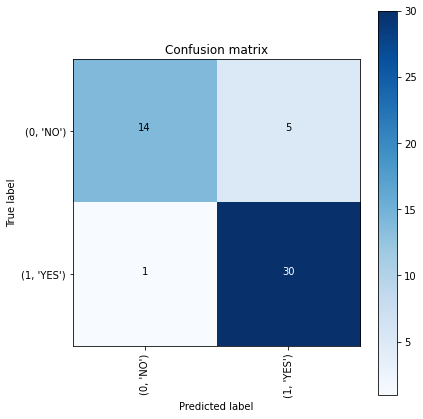

In [ ]:
# validate on val set
predictions = EfficientnetB0_.predict(X_val_prep)
predictions = [1 if x>0.25 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %f'%accuracy)
confusion_mtx = confusion_matrix(y_val, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

In [ ]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_val, predictions)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_val, predictions)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_val, predictions)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_val, predictions)
print('F1 score: %f' % f1)

Accuracy: 0.880000
Precision: 0.857143
Recall: 0.967742
F1 score: 0.909091


In [ ]:
kappa = cohen_kappa_score(y_val, predictions)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_val, predictions)
print('ROC AUC: %f' % auc)

Cohens kappa: 0.734513
ROC AUC: 0.852292


Test Accuracy = 0.90


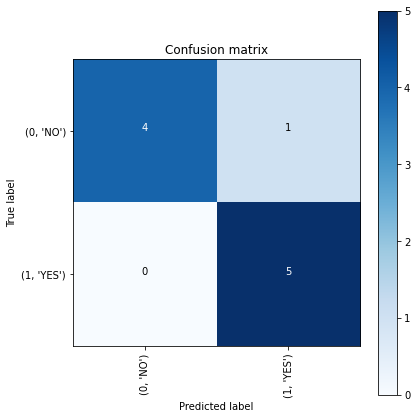

In [ ]:
# validate on test set
predictions = EfficientnetB0_.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

#### EfficientNetB1

In [ ]:

# load base model
EfficientNetB1_weight_path = '../input/keras-pretrained-models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
EfficientnetB1 = EfficientNetB1(
    weights='imagenet',
    include_top=False, 
    input_shape=IMG_SIZE + (3,)
)

27025408/27018416 [==============================] - 1s 0us/step


In [ ]:
from tensorflow import keras


NUM_CLASSES = 1

EfficientnetB1_ = Sequential()
EfficientnetB1_.add(EfficientnetB1)
EfficientnetB1_.add(layers.Dropout(0.3))
EfficientnetB1_.add(layers.Flatten())
EfficientnetB1_.add(layers.Dropout(0.5))
EfficientnetB1_.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

EfficientnetB1_.layers[0].trainable = False

EfficientnetB1_.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

EfficientnetB1_.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0003, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), metrics=["accuracy"])


EfficientnetB1_.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb1 (Functional)  (None, 7, 7, 1280)        6575239   
_________________________________________________________________
dropout_12 (Dropout)         (None, 7, 7, 1280)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 62720)             0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 62720)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 62721     
Total params: 6,637,960
Trainable params: 62,721
Non-trainable params: 6,575,239
_________________________________________________________________


In [ ]:
import time

start = time.time()

# early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)

EfficientnetB1_history = EfficientnetB1_.fit_generator(
    train_generator,
    steps_per_epoch=6,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
)

end = time.time()
print(end - start)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/50
6/6 [==============================] - 30s 4s/step - loss: 1.0020 - accuracy: 0.4935 - val_loss: 0.5130 - val_accuracy: 0.7000
Epoch 2/50
6/6 [==============================] - 18s 4s/step - loss: 0.8751 - accuracy: 0.5927 - val_loss: 0.4214 - val_accuracy: 0.8000
Epoch 3/50
6/6 [==============================] - 19s 3s/step - loss: 0.6989 - accuracy: 0.6649 - val_loss: 0.4548 - val_accuracy: 0.7800
Epoch 4/50
6/6 [==============================] - 18s 3s/step - loss: 0.5533 - accuracy: 0.7582 - val_loss: 0.4233 - val_accuracy: 0.8400
Epoch 5/50
6/6 [==============================] - 19s 3s/step - loss: 0.4944 - accuracy: 0.7635 - val_loss: 0.3387 - val_accuracy: 0.8400
Epoch 6/50
6/6 [==============================] - 18s 4s/step - loss: 0.3968 - accuracy: 0.8478 - val_loss: 0.3194 - val_accuracy: 0.9000
Epoch 7/50
6/6 [==============================] - 18s 3s/step - loss: 0.3503 - accuracy: 0.8177 - val_loss: 0.3779 - val_accuracy: 0.8600
Epoch 8/50
6/6 [==================

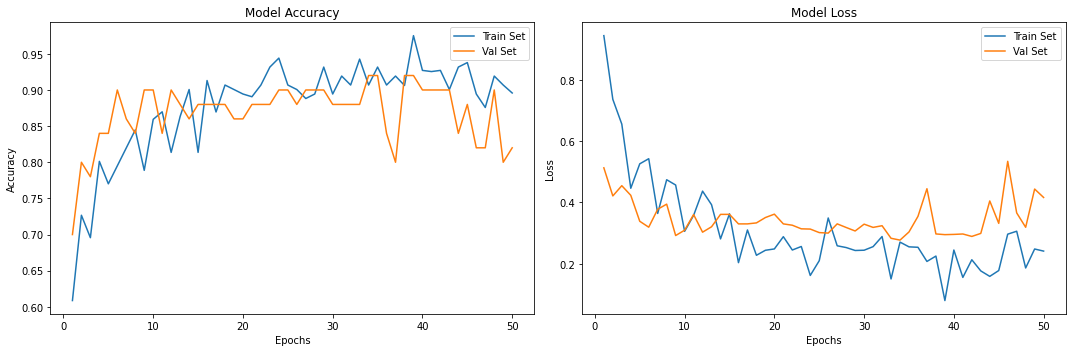

In [ ]:
# plot model performance
acc = EfficientnetB1_history.history['accuracy']
val_acc = EfficientnetB1_history.history['val_accuracy']
loss = EfficientnetB1_history.history['loss']
val_loss = EfficientnetB1_history.history['val_loss']
epochs_range = range(1, len(EfficientnetB1_history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

Val Accuracy = 0.740000


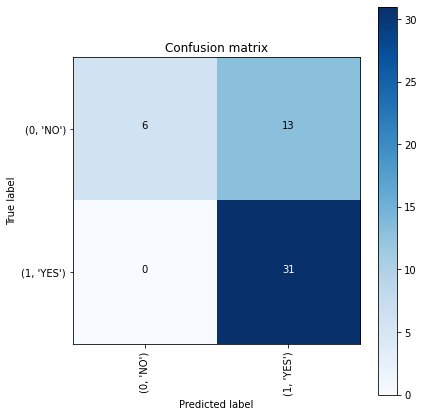

In [ ]:
# validate on val set
predictions = EfficientnetB1_.predict(X_val_prep)
predictions = [1 if x>0.25 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %f'%accuracy)
confusion_mtx = confusion_matrix(y_val, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

In [ ]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_val, predictions)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_val, predictions)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_val, predictions)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_val, predictions)
print('F1 score: %f' % f1)

Accuracy: 0.740000
Precision: 0.704545
Recall: 1.000000
F1 score: 0.826667


In [ ]:
kappa = cohen_kappa_score(y_val, predictions)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_val, predictions)
print('ROC AUC: %f' % auc)

Cohens kappa: 0.363992
ROC AUC: 0.657895


Test Accuracy = 0.90


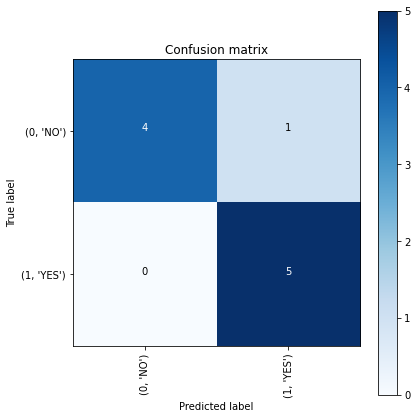

In [ ]:
# validate on test set
predictions = EfficientnetB1_.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

#### EffiecintNetB2

In [ ]:

# load base model
EfficientNetB2_weight_path = '../input/keras-pretrained-models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
EfficientnetB2 = EfficientNetB2(
    weights='imagenet',
    include_top=False, 
    input_shape=IMG_SIZE + (3,)
)

31793152/31790344 [==============================] - 1s 0us/step


In [ ]:
from tensorflow import keras


NUM_CLASSES = 1

EfficientnetB2_ = Sequential()
EfficientnetB2_.add(EfficientnetB2)
EfficientnetB2_.add(layers.Dropout(0.3))
EfficientnetB2_.add(layers.Flatten())
EfficientnetB2_.add(layers.Dropout(0.5))
EfficientnetB2_.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

EfficientnetB2_.layers[0].trainable = False

EfficientnetB2_.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

EfficientnetB2_.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0003, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), metrics=["accuracy"])


EfficientnetB2_.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb2 (Functional)  (None, 7, 7, 1408)        7768569   
_________________________________________________________________
dropout_14 (Dropout)         (None, 7, 7, 1408)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 68992)             0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 68992)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 68993     
Total params: 7,837,562
Trainable params: 68,993
Non-trainable params: 7,768,569
_________________________________________________________________


In [ ]:
import time

start = time.time()

# early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)

EfficientnetB2_history = EfficientnetB2_.fit_generator(
    train_generator,
    steps_per_epoch=6,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
)

end = time.time()
print(end - start)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/50
6/6 [==============================] - 32s 5s/step - loss: 0.7732 - accuracy: 0.6257 - val_loss: 0.8768 - val_accuracy: 0.6200
Epoch 2/50
6/6 [==============================] - 20s 3s/step - loss: 0.5348 - accuracy: 0.7708 - val_loss: 0.4310 - val_accuracy: 0.8200
Epoch 3/50
6/6 [==============================] - 20s 3s/step - loss: 0.6321 - accuracy: 0.7197 - val_loss: 0.4205 - val_accuracy: 0.8000
Epoch 4/50
6/6 [==============================] - 20s 3s/step - loss: 0.6093 - accuracy: 0.7328 - val_loss: 0.3704 - val_accuracy: 0.8800
Epoch 5/50
6/6 [==============================] - 20s 3s/step - loss: 0.3709 - accuracy: 0.8318 - val_loss: 0.3870 - val_accuracy: 0.8400
Epoch 6/50
6/6 [==============================] - 20s 3s/step - loss: 0.4057 - accuracy: 0.8335 - val_loss: 0.3953 - val_accuracy: 0.8600
Epoch 7/50
6/6 [==============================] - 20s 4s/step - loss: 0.7228 - accuracy: 0.7170 - val_loss: 0.5053 - val_accuracy: 0.8400
Epoch 8/50
6/6 [==================

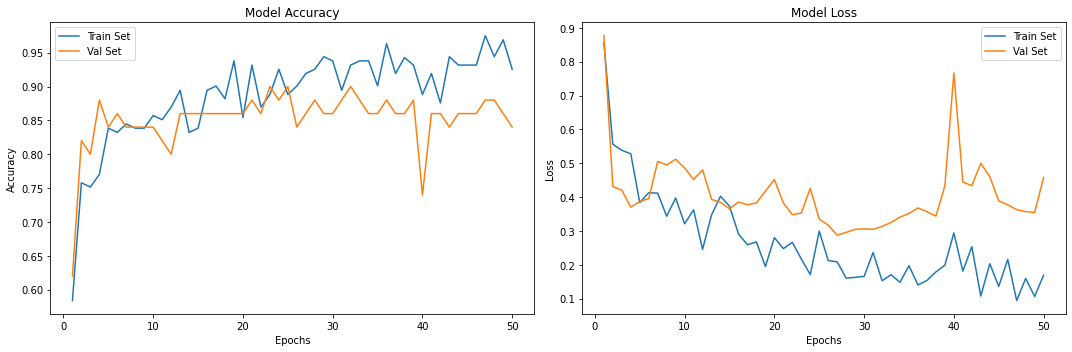

In [ ]:
# plot model performance
acc = EfficientnetB2_history.history['accuracy']
val_acc = EfficientnetB2_history.history['val_accuracy']
loss = EfficientnetB2_history.history['loss']
val_loss = EfficientnetB2_history.history['val_loss']
epochs_range = range(1, len(EfficientnetB2_history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

Val Accuracy = 0.880000


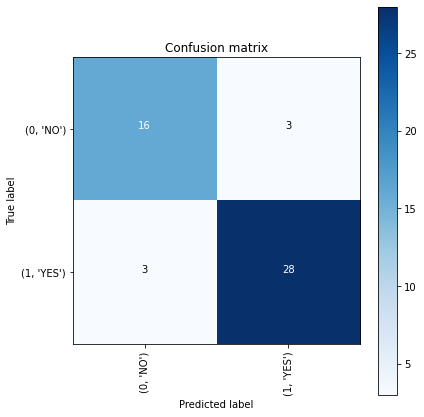

In [ ]:
# validate on val set
predictions = EfficientnetB2_.predict(X_val_prep)
predictions = [1 if x>0.25 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %f'%accuracy)
confusion_mtx = confusion_matrix(y_val, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

In [ ]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_val, predictions)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_val, predictions)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_val, predictions)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_val, predictions)
print('F1 score: %f' % f1)

Accuracy: 0.880000
Precision: 0.903226
Recall: 0.903226
F1 score: 0.903226


In [ ]:
kappa = cohen_kappa_score(y_val, predictions)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_val, predictions)
print('ROC AUC: %f' % auc)

Cohens kappa: 0.745331
ROC AUC: 0.872666


Test Accuracy = 0.90


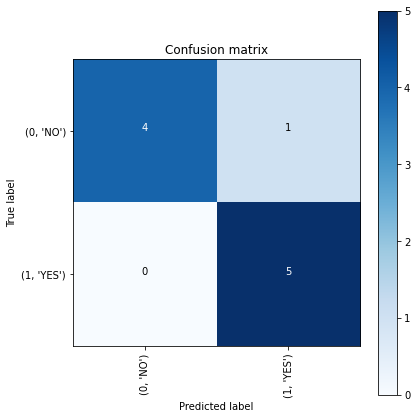

In [ ]:
# validate on test set
predictions = EfficientnetB2_.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

#### EfficientNetB3

In [ ]:

# load base model
EfficientNetB3_weight_path = '../input/keras-pretrained-models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
EfficientnetB3 = EfficientNetB3(
    weights='imagenet',
    include_top=False, 
    input_shape=IMG_SIZE + (3,)
)

43941888/43941136 [==============================] - 0s 0us/step


In [ ]:
from tensorflow import keras


NUM_CLASSES = 1

EfficientnetB3_ = Sequential()
EfficientnetB3_.add(EfficientnetB3)
EfficientnetB3_.add(layers.Dropout(0.3))
EfficientnetB3_.add(layers.Flatten())
EfficientnetB3_.add(layers.Dropout(0.5))
EfficientnetB3_.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

EfficientnetB3_.layers[0].trainable = False

EfficientnetB3_.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

EfficientnetB3_.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0003, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), metrics=["accuracy"])


EfficientnetB3_.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 7, 7, 1536)        10783535  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 1536)        0         
_________________________________________________________________
flatten (Flatten)            (None, 75264)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 75264)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 75265     
Total params: 10,858,800
Trainable params: 75,265
Non-trainable params: 10,783,535
_________________________________________________________________


In [ ]:
import time

start = time.time()

# early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)

EfficientnetB3_history = EfficientnetB3_.fit_generator(
    train_generator,
    steps_per_epoch=6,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
)

end = time.time()
print(end - start)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/50
6/6 [==============================] - 39s 5s/step - loss: 0.9594 - accuracy: 0.5522 - val_loss: 0.5404 - val_accuracy: 0.7400
Epoch 2/50
6/6 [==============================] - 26s 4s/step - loss: 0.4545 - accuracy: 0.8309 - val_loss: 0.6074 - val_accuracy: 0.7000
Epoch 3/50
6/6 [==============================] - 25s 4s/step - loss: 0.5488 - accuracy: 0.8054 - val_loss: 0.3628 - val_accuracy: 0.8800
Epoch 4/50
6/6 [==============================] - 26s 5s/step - loss: 0.5145 - accuracy: 0.7000 - val_loss: 0.4146 - val_accuracy: 0.8400
Epoch 5/50
6/6 [==============================] - 26s 4s/step - loss: 0.5231 - accuracy: 0.8161 - val_loss: 0.3244 - val_accuracy: 0.8600
Epoch 6/50
6/6 [==============================] - 26s 4s/step - loss: 0.3125 - accuracy: 0.8860 - val_loss: 0.2915 - val_accuracy: 0.9200
Epoch 7/50
6/6 [==============================] - 26s 4s/step - loss: 0.4439 - accuracy: 0.8323 - val_loss: 0.3549 - val_accuracy: 0.8800
Epoch 8/50
6/6 [==================

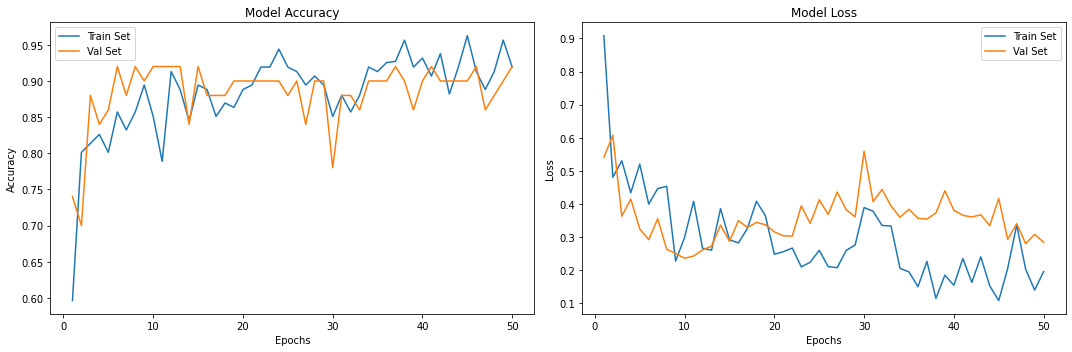

In [ ]:
# plot model performance
acc = EfficientnetB3_history.history['accuracy']
val_acc = EfficientnetB3_history.history['val_accuracy']
loss = EfficientnetB3_history.history['loss']
val_loss = EfficientnetB3_history.history['val_loss']
epochs_range = range(1, len(EfficientnetB3_history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

Val Accuracy = 0.940000


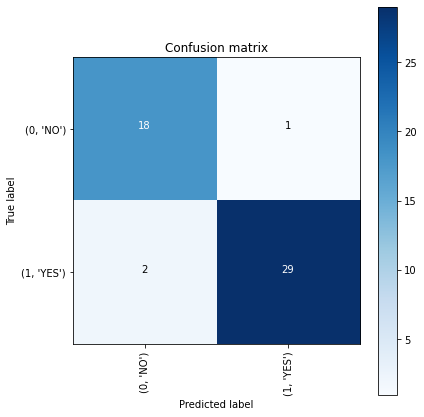

In [ ]:
# validate on val set
predictions = EfficientnetB3_.predict(X_val_prep)
predictions = [1 if x>0.75 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %f'%accuracy)
confusion_mtx = confusion_matrix(y_val, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

In [ ]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_val, predictions)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_val, predictions)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_val, predictions)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_val, predictions)
print('F1 score: %f' % f1)

Accuracy: 0.940000
Precision: 0.966667
Recall: 0.935484
F1 score: 0.950820


In [ ]:
kappa = cohen_kappa_score(y_val, predictions)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_val, predictions)
print('ROC AUC: %f' % auc)

Cohens kappa: 0.873950
ROC AUC: 0.941426


Test Accuracy = 1.00


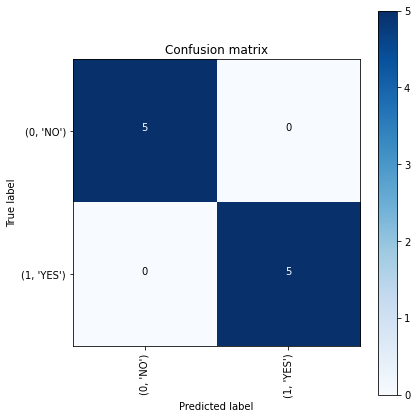

In [ ]:
# validate on test set
predictions = EfficientnetB3_.predict(X_test_prep)
predictions = [1 if x>0.75 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

#### EfficientNetB4

In [ ]:

# load base model
EfficientNetB4_weight_path = '../input/keras-pretrained-models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
EfficientnetB4 = EfficientNetB4(
    weights='imagenet',
    include_top=False, 
    input_shape=IMG_SIZE + (3,)
)

71688192/71686520 [==============================] - 2s 0us/step


In [ ]:
from tensorflow import keras


NUM_CLASSES = 1

EfficientnetB4_ = Sequential()
EfficientnetB4_.add(EfficientnetB4)
EfficientnetB4_.add(layers.Dropout(0.3))
EfficientnetB4_.add(layers.Flatten())
EfficientnetB4_.add(layers.Dropout(0.5))
EfficientnetB4_.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

EfficientnetB4_.layers[0].trainable = False

EfficientnetB4_.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

EfficientnetB4_.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0003, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), metrics=["accuracy"])


EfficientnetB4_.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb4 (Functional)  (None, 7, 7, 1792)        17673823  
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 1792)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 87808)             0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 87808)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 87809     
Total params: 17,761,632
Trainable params: 87,809
Non-trainable params: 17,673,823
_________________________________________________________________


In [ ]:
import time

start = time.time()

# early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)

EfficientnetB4_history = EfficientnetB4_.fit_generator(
    train_generator,
    steps_per_epoch=6,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
)

end = time.time()
print(end - start)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/50
6/6 [==============================] - 62s 8s/step - loss: 0.6452 - accuracy: 0.6420 - val_loss: 1.2380 - val_accuracy: 0.6200
Epoch 2/50
6/6 [==============================] - 45s 9s/step - loss: 0.6288 - accuracy: 0.7591 - val_loss: 0.5429 - val_accuracy: 0.8000
Epoch 3/50
6/6 [==============================] - 37s 6s/step - loss: 0.5050 - accuracy: 0.7551 - val_loss: 0.7251 - val_accuracy: 0.7400
Epoch 4/50
6/6 [==============================] - 36s 6s/step - loss: 0.5841 - accuracy: 0.7534 - val_loss: 0.4995 - val_accuracy: 0.8600
Epoch 5/50
6/6 [==============================] - 43s 7s/step - loss: 0.4315 - accuracy: 0.8233 - val_loss: 0.6435 - val_accuracy: 0.7800
Epoch 6/50
6/6 [==============================] - 38s 6s/step - loss: 0.2197 - accuracy: 0.9041 - val_loss: 0.5035 - val_accuracy: 0.8800
Epoch 7/50
6/6 [==============================] - 41s 7s/step - loss: 0.3571 - accuracy: 0.8676 - val_loss: 0.4867 - val_accuracy: 0.8600
Epoch 8/50
6/6 [==================

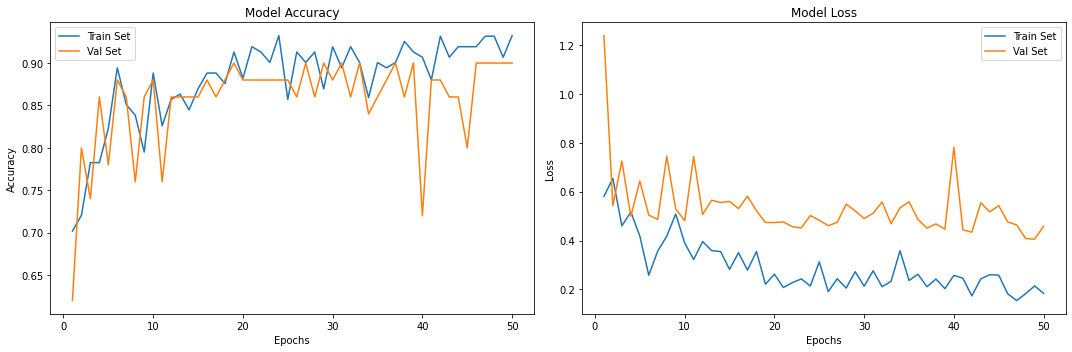

In [ ]:
# plot model performance
acc = EfficientnetB4_history.history['accuracy']
val_acc = EfficientnetB4_history.history['val_accuracy']
loss = EfficientnetB4_history.history['loss']
val_loss = EfficientnetB4_history.history['val_loss']
epochs_range = range(1, len(EfficientnetB4_history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

Val Accuracy = 0.860000


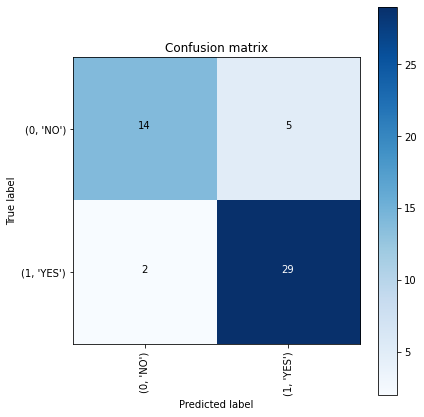

In [ ]:
# validate on val set
predictions = EfficientnetB4_.predict(X_val_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %f'%accuracy)
confusion_mtx = confusion_matrix(y_val, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

In [ ]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_val, predictions)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_val, predictions)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_val, predictions)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_val, predictions)
print('F1 score: %f' % f1)

Accuracy: 0.860000
Precision: 0.852941
Recall: 0.935484
F1 score: 0.892308


In [ ]:
kappa = cohen_kappa_score(y_val, predictions)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_val, predictions)
print('ROC AUC: %f' % auc)

Cohens kappa: 0.693520
ROC AUC: 0.836163


Test Accuracy = 0.90


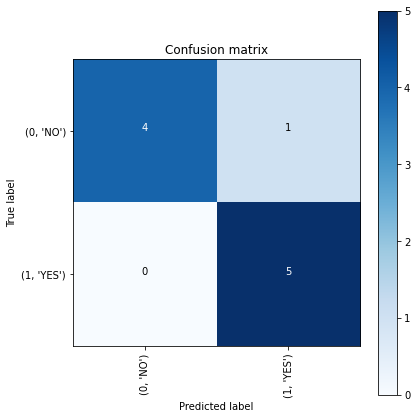

In [ ]:
# validate on test set
predictions = EfficientnetB4_.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

#### EfficientNetB5

In [ ]:

# load base model
EfficientNetB5_weight_path = '../input/keras-pretrained-models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
EfficientnetB5 = EfficientNetB5(
    weights='imagenet',
    include_top=False, 
    input_shape=IMG_SIZE + (3,)
)

115269632/115263384 [==============================] - 3s 0us/step


In [ ]:
from tensorflow import keras


NUM_CLASSES = 1

EfficientnetB5_ = Sequential()
EfficientnetB5_.add(EfficientnetB5)
EfficientnetB5_.add(layers.Dropout(0.3))
EfficientnetB5_.add(layers.Flatten())
EfficientnetB5_.add(layers.Dropout(0.5))
EfficientnetB5_.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

EfficientnetB5_.layers[0].trainable = False

EfficientnetB5_.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

EfficientnetB5_.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0003, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), metrics=["accuracy"])


EfficientnetB5_.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb5 (Functional)  (None, 7, 7, 2048)        28513527  
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 7, 2048)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 100352)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 100353    
Total params: 28,613,880
Trainable params: 100,353
Non-trainable params: 28,513,527
_________________________________________________________________


In [ ]:
import time

start = time.time()

# early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)

EfficientnetB5_history = EfficientnetB5_.fit_generator(
    train_generator,
    steps_per_epoch=6,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
)

end = time.time()
print(end - start)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/50
6/6 [==============================] - 76s 10s/step - loss: 1.1877 - accuracy: 0.5738 - val_loss: 1.2488 - val_accuracy: 0.6200
Epoch 2/50
6/6 [==============================] - 53s 9s/step - loss: 1.1195 - accuracy: 0.6797 - val_loss: 1.8970 - val_accuracy: 0.4600
Epoch 3/50
6/6 [==============================] - 53s 9s/step - loss: 0.9504 - accuracy: 0.7417 - val_loss: 0.7362 - val_accuracy: 0.7400
Epoch 4/50
6/6 [==============================] - 54s 9s/step - loss: 0.9112 - accuracy: 0.7622 - val_loss: 0.4938 - val_accuracy: 0.8400
Epoch 5/50
6/6 [==============================] - 52s 9s/step - loss: 0.7333 - accuracy: 0.7208 - val_loss: 0.9199 - val_accuracy: 0.6800
Epoch 6/50
6/6 [==============================] - 52s 9s/step - loss: 0.6861 - accuracy: 0.7303 - val_loss: 0.5279 - val_accuracy: 0.8000
Epoch 7/50
6/6 [==============================] - 51s 10s/step - loss: 0.6009 - accuracy: 0.7090 - val_loss: 0.3795 - val_accuracy: 0.8400
Epoch 8/50
6/6 [================

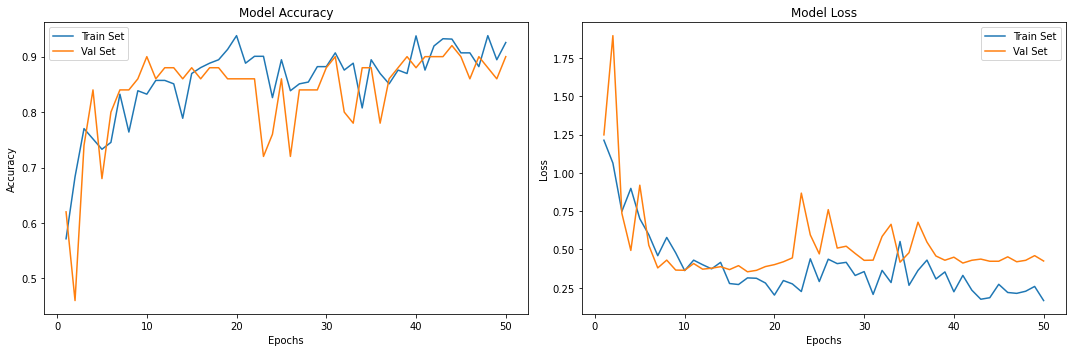

In [ ]:
# plot model performance
acc = EfficientnetB5_history.history['accuracy']
val_acc = EfficientnetB5_history.history['val_accuracy']
loss = EfficientnetB5_history.history['loss']
val_loss = EfficientnetB5_history.history['val_loss']
epochs_range = range(1, len(EfficientnetB5_history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

Val Accuracy = 0.900000


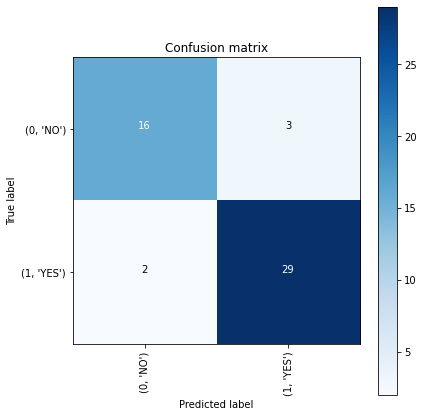

In [ ]:
# validate on val set
predictions = EfficientnetB5_.predict(X_val_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %f'%accuracy)
confusion_mtx = confusion_matrix(y_val, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

In [ ]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_val, predictions)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_val, predictions)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_val, predictions)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_val, predictions)
print('F1 score: %f' % f1)

Accuracy: 0.900000
Precision: 0.906250
Recall: 0.935484
F1 score: 0.920635


In [ ]:
kappa = cohen_kappa_score(y_val, predictions)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_val, predictions)
print('ROC AUC: %f' % auc)

Cohens kappa: 0.785592
ROC AUC: 0.888795


Test Accuracy = 0.90


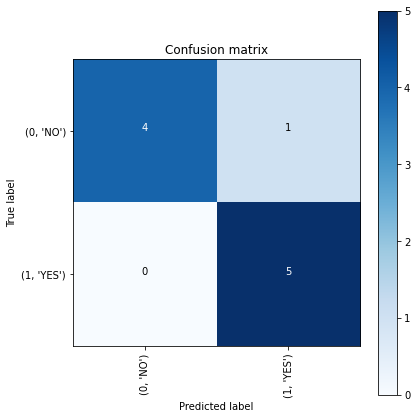

In [ ]:
# validate on test set
predictions = EfficientnetB5_.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

#### EfficientNetB6

In [ ]:

# load base model
EfficientNetB6_weight_path = '../input/keras-pretrained-models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
EfficientnetB6 = EfficientNetB6(
    weights='imagenet',
    include_top=False, 
    input_shape=IMG_SIZE + (3,)
)

165240832/165234480 [==============================] - 3s 0us/step


In [ ]:
from tensorflow import keras


NUM_CLASSES = 1

EfficientnetB6_ = Sequential()
EfficientnetB6_.add(EfficientnetB6)
EfficientnetB6_.add(layers.Dropout(0.3))
EfficientnetB6_.add(layers.Flatten())
EfficientnetB6_.add(layers.Dropout(0.5))
EfficientnetB6_.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

EfficientnetB6_.layers[0].trainable = False

EfficientnetB6_.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

EfficientnetB6_.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0003, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), metrics=["accuracy"])


EfficientnetB6_.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb6 (Functional)  (None, 7, 7, 2304)        40960143  
_________________________________________________________________
dropout_6 (Dropout)          (None, 7, 7, 2304)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 112896)            0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 112896)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 112897    
Total params: 41,073,040
Trainable params: 112,897
Non-trainable params: 40,960,143
_________________________________________________________________


In [ ]:
import time

start = time.time()

# early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)

EfficientnetB6_history = EfficientnetB6_.fit_generator(
    train_generator,
    steps_per_epoch=6,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
)

end = time.time()
print(end - start)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/50
6/6 [==============================] - 100s 14s/step - loss: 0.7920 - accuracy: 0.5986 - val_loss: 0.7687 - val_accuracy: 0.6400
Epoch 2/50
6/6 [==============================] - 64s 13s/step - loss: 0.6161 - accuracy: 0.7418 - val_loss: 0.7024 - val_accuracy: 0.6800
Epoch 3/50
6/6 [==============================] - 64s 11s/step - loss: 0.4606 - accuracy: 0.7644 - val_loss: 0.7301 - val_accuracy: 0.7200
Epoch 4/50
6/6 [==============================] - 67s 11s/step - loss: 0.5051 - accuracy: 0.7621 - val_loss: 0.5877 - val_accuracy: 0.7800
Epoch 5/50
6/6 [==============================] - 67s 11s/step - loss: 0.4251 - accuracy: 0.8528 - val_loss: 0.5106 - val_accuracy: 0.8400
Epoch 6/50
6/6 [==============================] - 75s 13s/step - loss: 0.4083 - accuracy: 0.8597 - val_loss: 0.4486 - val_accuracy: 0.8800
Epoch 7/50
6/6 [==============================] - 68s 11s/step - loss: 0.3476 - accuracy: 0.8485 - val_loss: 0.4379 - val_accuracy: 0.8600
Epoch 8/50
6/6 [==========

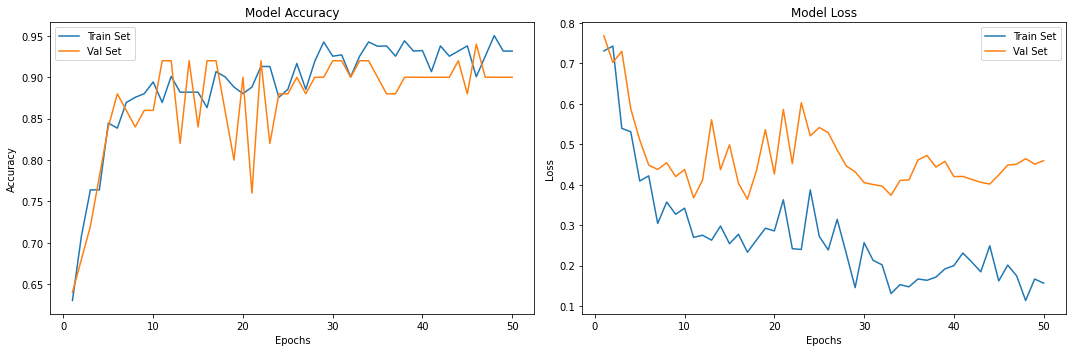

In [ ]:
# plot model performance
acc = EfficientnetB6_history.history['accuracy']
val_acc = EfficientnetB6_history.history['val_accuracy']
loss = EfficientnetB6_history.history['loss']
val_loss = EfficientnetB6_history.history['val_loss']
epochs_range = range(1, len(EfficientnetB6_history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

Val Accuracy = 0.900000


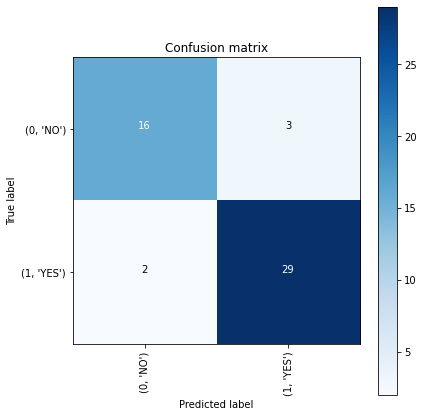

In [ ]:
# validate on val set
predictions = EfficientnetB6_.predict(X_val_prep)
predictions = [1 if x>0.75 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %f'%accuracy)
confusion_mtx = confusion_matrix(y_val, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

In [ ]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_val, predictions)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_val, predictions)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_val, predictions)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_val, predictions)
print('F1 score: %f' % f1)

Accuracy: 0.900000
Precision: 0.906250
Recall: 0.935484
F1 score: 0.920635


In [ ]:
kappa = cohen_kappa_score(y_val, predictions)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_val, predictions)
print('ROC AUC: %f' % auc)

Cohens kappa: 0.785592
ROC AUC: 0.888795


Test Accuracy = 1.00


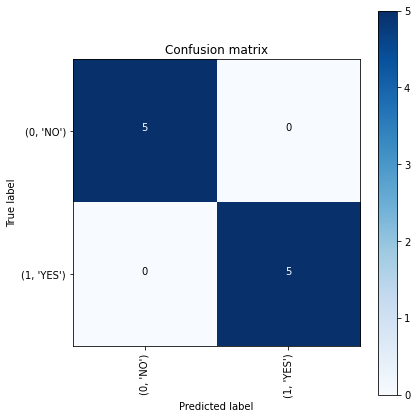

In [ ]:
# validate on test set
predictions = EfficientnetB6_.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

#### EfficientNetB7

In [ ]:

# load base model
EfficientNetB7_weight_path = '../input/keras-pretrained-models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
EfficientnetB7 = EfficientNetB7(
    weights='imagenet',
    include_top=False, 
    input_shape=IMG_SIZE + (3,)
)

258080768/258076736 [==============================] - 7s 0us/step


In [ ]:
from tensorflow import keras


NUM_CLASSES = 1

EfficientnetB7_ = Sequential()
EfficientnetB7_.add(EfficientnetB7)
EfficientnetB7_.add(layers.Dropout(0.3))
EfficientnetB7_.add(layers.Flatten())
EfficientnetB7_.add(layers.Dropout(0.5))
EfficientnetB7_.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

EfficientnetB7_.layers[0].trainable = False

EfficientnetB7_.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

EfficientnetB7_.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0003, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), metrics=["accuracy"])


EfficientnetB7_.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb7 (Functional)  (None, 7, 7, 2560)        64097687  
_________________________________________________________________
dropout_8 (Dropout)          (None, 7, 7, 2560)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 125440)            0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 125440)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 125441    
Total params: 64,223,128
Trainable params: 125,441
Non-trainable params: 64,097,687
_________________________________________________________________


In [ ]:
import time

start = time.time()

# early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)

EfficientnetB7_history = EfficientnetB7_.fit_generator(
    train_generator,
    steps_per_epoch=6,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
)

end = time.time()
print(end - start)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/50
6/6 [==============================] - 119s 16s/step - loss: 1.1698 - accuracy: 0.4655 - val_loss: 1.7556 - val_accuracy: 0.6200
Epoch 2/50
6/6 [==============================] - 89s 15s/step - loss: 0.9758 - accuracy: 0.7038 - val_loss: 0.6876 - val_accuracy: 0.7600
Epoch 3/50
6/6 [==============================] - 89s 15s/step - loss: 0.6953 - accuracy: 0.7372 - val_loss: 0.6448 - val_accuracy: 0.7400
Epoch 4/50
6/6 [==============================] - 88s 17s/step - loss: 0.4710 - accuracy: 0.8055 - val_loss: 0.6256 - val_accuracy: 0.8400
Epoch 5/50
6/6 [==============================] - 88s 15s/step - loss: 0.4251 - accuracy: 0.8329 - val_loss: 0.5531 - val_accuracy: 0.8400
Epoch 6/50
6/6 [==============================] - 89s 15s/step - loss: 0.3592 - accuracy: 0.8511 - val_loss: 0.5587 - val_accuracy: 0.7800
Epoch 7/50
6/6 [==============================] - 102s 18s/step - loss: 0.4284 - accuracy: 0.8208 - val_loss: 0.5423 - val_accuracy: 0.8200
Epoch 8/50
6/6 [=========

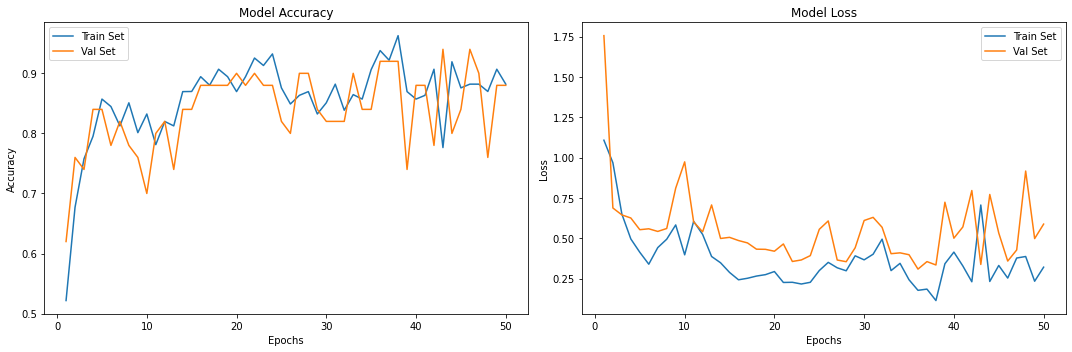

In [ ]:
# plot model performance
acc = EfficientnetB7_history.history['accuracy']
val_acc = EfficientnetB7_history.history['val_accuracy']
loss = EfficientnetB7_history.history['loss']
val_loss = EfficientnetB7_history.history['val_loss']
epochs_range = range(1, len(EfficientnetB7_history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

Val Accuracy = 0.800000


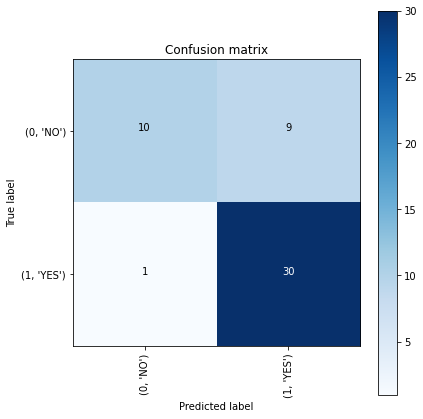

In [ ]:
# validate on val set
predictions = EfficientnetB7_.predict(X_val_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %f'%accuracy)
confusion_mtx = confusion_matrix(y_val, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

In [ ]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_val, predictions)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_val, predictions)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_val, predictions)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_val, predictions)
print('F1 score: %f' % f1)

Accuracy: 0.800000
Precision: 0.769231
Recall: 0.967742
F1 score: 0.857143


In [ ]:
kappa = cohen_kappa_score(y_val, predictions)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_val, predictions)
print('ROC AUC: %f' % auc)

Cohens kappa: 0.537893
ROC AUC: 0.747029


Test Accuracy = 1.00


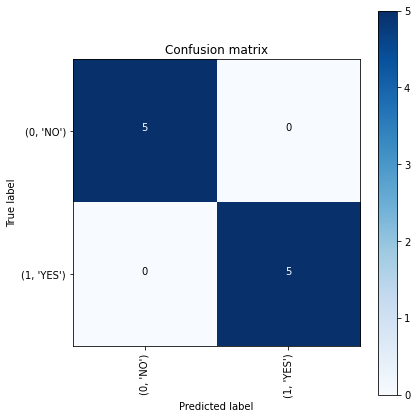

In [ ]:
# validate on test set
predictions = EfficientnetB7_.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)